# Recurrent Neural Networks - LSTM

¿Quieres sentirte como Mozart pero no tienes ni idea de lo que es un acorde ni tampoco lo que es una corchea? Bueno, aquí tendrás una idea de como puedes componer música sin tan siquiera tocar la flauta dulce.

La idea de este *notebook* no es original, sino que está basada en [este maravilloso artículo](https://arxiv.org/pdf/1711.07682.pdf) el cual es prácticamente obligatorio ir leyendo a medida que vamos a ir trabajando en la elaboración de un modelo que nos analice y cree unos acordes en función de los archivos *.midi* que tengamos sobre una canción. También hay que mencionar que no elaboraremos un modelo tan complejo como el que se ve en el artículo dado que eso nos llevaría mucho tiempo, no solo de quebrarnos la cabeza, sino también de tiempo de ejecución de nuestro código, de todos modos, si se entiende correctamente lo que vamos a ir haciendo es probable que de el gusanillo de ir más allá así que, recomiendo encarecidamente prestar atención al [artículo](https://arxiv.org/pdf/1711.07682.pdf).

¡Y otra cosa! Puede que queráis implementar el código en vuestros ordenadores y tengáis el problema de, o bien, vuestro ordenador tiene el mismo *hardware* que una piedra o bien os apetezca meteros entre pecho y espalda una lectura práctica en un dispositivo "ultra" portatil como lo sería un *iPad*. ¡Estáis de enhorabuena! Podéis ejecutar código en la nube, quizás muchos de vosotros conozcáis lo que es [*Google Colab*](https://colab.research.google.com/?hl=es), pero para aquellos que no, tal y como dicen los chicos *Mountain View* *"Google Colab es un producto de Google Research. Permite a cualquier usuario escribir y ejecutar código arbitrario de Python en el navegador."*. Esto significa que con contar con una cuenta *Google* váis a disponer de una herramienta en la nube que os permitirá correr código, ¿nada mal no?. Hay otras herramientas, como la que nos ofrece *Kaggle* o *Amazon*, pero por la sencillez que ofrece *Google* voy a recomendar por el momento *Google Colab* y es en el entorno en el cual vamos a ejecutar el código.

Y ya sí que sí, por último, me gustaría mencionar que es probable que si no has programado lo suficiente en *Python* como si no tienes ni idea de que es el *Machine Learning*, vas a estar más perdido que un piojo en una calva, por lo que te recomendaría que indagases antes en algún curso que te ayude a adquirir tanto conocimientos en programación (y específicamente con el lenguaje Python) como en *Machine Learning*.

Ahora si que sí, ¡vamos al lío!.

# 0. Contexto
Tal y como estamos acostumbrados en minería de datos o en cualquier tarea de *Machine Learning* (a partir de ahora ML para evitar la pedantería) vamos a seguir los pasos más comunes, que consisten en:

1. Interpretamos el *set de datos* con los que vamos a trabajar. La idea es reproducir en parte los resultados que se obtienen en el [artículo](https://colab.research.google.com/?hl=es).
2. Crearemos una red neuronal recurrente con el objetivo de entrenarla como a Rocky.
3. Observaremos la capa *embedding* (*keep calm* que veremos que es eso) de nuestro modelo entrenado para ver los acordes que está generando en 2D. Esto nos ayudará a visualizar el concepto de [word2vec](https://en.wikipedia.org/wiki/Word2vec).

> **NOTA**: Es recomendable (o mejor dicho obligatorio) el visitar los enlaces que vamos colocando a lo largo de este *notebook* para evitar agobiarnos tanto como *Spiderman* en un descampado.

También es importante leerse el *README.md* para comprender como es la estructura de las carpetas y archivos que vamos a trabajar. Si no controláis lo que estamos haciendo, es mejor que no toquéis ninguna carpeta ni tampoco toquéis el nombre de los archivos ni nada por el estilo, es decir, os descargáis el *.zip* de *GitHub* y ejecutáis el *notebook* tal cual se os descomprime. De esta manera no habrá problemas si queréis recrear cada uno de los *chunks* que vamos a ver.

# 1. Procesado de los datos
## 1.1. Importación de los módulos y las librerías necesarias

Realmente, no es necesario escuchar los archivos de audio para la elaboración de nuestro modelo, ya que el mismo modelo se encargará de estudiar música por nosotros :P. No obstante, se que muchos tienen la misma curiosidad que un gato, por lo tanto, vamos a realizar la instalación de una serie de librerías que nos permitan escuchar los fabulosos archivos *.midi* que vamos a trabajar.

In [1]:
# Instalamos librerías
!pip install pretty_midi==0.2.8 # Esto si que es obligatorio
#sudo apt install -y fluidsynth # (Opcional) Para la reproducción de los archivos .midi
#!pip install --upgrade pyfluidsynth # (Opcional) Para la actualización

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.6 MB 4.9 MB/s 
     |████████████████████████████████| 51 kB 7.5 MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.8-py3-none-any.whl size=5590821 sha256=a454624afb1e8546476ded04c37529378e5e865f26c4283e2d19e4fd9907e79a
  Stored in directory: /root/.cache/pip/wheels/53/fd/dd/20e1b16dbcf028bbbd7f53b570bc3521183731cba4a73cb310
Successfully built pretty-midi


Y ¡ojo!, necesitamos trastear con nuestros archivos, es por ello que si habéis tomado la recomendación de trabajar con *Google Colab* vamos a preparar nuestro entorno para poder manejar los archivos.

In [16]:
# Importamos drive para trabajar con nuestros archivos en la nube
from google.colab import drive
drive.mount('/content/drive')

# Establecemos la carpeta donde queremos los archivos
%cd ./drive/MyDrive/GitHub-Projects/Project-RNN-Chords
# %cd y la ruta de los archivos, en nuestro caso es la que se ve anteriormente

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/GitHub-Projects/Project-RNN-Chords


Una vez montado nuestro *setup* vamos a importar las librerías que vamos a usar en nuestro *notebook*.

In [17]:
# Importamos librerías
import numpy as np
import matplotlib.pyplot as plt
import _pickle as pickle
import os
import sys
import pretty_midi as pm
import mido
from collections import Counter
import collections
import pandas as pd
import glob

# Para conocer aproximádamente la demora de un bucle
import tqdm

# Para la elección aleatoria de elementos
import random

# Para el cálculo de la distancia euclidea
from scipy.spatial.distance import euclidean
import math

# Para emplear gráficas de Seaborn
import seaborn as sns

# Para la reproducción de los audios
#import fluidsynth

# Emplearemos el estilo gráfico de ggplot
# Para emplear el estilo de ggplot
from matplotlib import style
style.use("ggplot") or plt.style.use("ggplot")

# Omitiremos las advertencias para no entorpecer en el visualizado
import warnings
warnings.filterwarnings('ignore')

Hasta aquí hemos importado las librerías que necesitamos, no obstante, para llevar a cabo una reproducción similar a la que se nos muestra en el [articulo](https://arxiv.org/pdf/1711.07682.pdf) vamos a necesitar importar algunas de las funciones que tienen los módulos que nos dejan en el [GitHub](https://github.com/brunnergino/JamBot) del proyecto. En nuestro *GitHub* vamos a incluirlo, no obstante, conviene que se vaya al del proyecto original para ver que es lo que se hace exactamente.

Una vez que tengamos nuestros módulos en nuestro ordenador bastará con importar.

In [47]:
# Importación de las funciones del paper
from settings import *
import midi_functions as mf 
import data_processing_functions as dpf

Y por último, siempre gusta tener un código bien ejecutado. Por suerte, en Python contamos con el [PEP 8](https://peps.python.org/pep-0008/) que nos da las pautas para escribir un buen código de Python como Dios manda. Dado que es una pereza absoluta tener que estar leyendo el [PEP 8](https://peps.python.org/pep-0008/) y revisar código constantemente, os dejamos a continuación la instalación de un módulo para la revisión de estilo, aunque la mala noticia es que en *Google Colab* no se podrá ejecutar (de ahí que se deje comentada) aunque en local se puede instalar y testear.

In [ ]:
# Instalamos el módulo pycodestyle y flake8
#conda install -c conda-forge pycodestyle
#conda install flake8 pycodestyle_magic

# Activamos alertas de estilo
#%load_ext pycodestyle_magic
#%pycodestyle_on

Al fin tenemos todo listo para lanzarnos a la piscina de cabeza, vamos a realizar una exploración de los archivos con los que trabajaremos.

## 1.2. Ficheros MIDI
¿Qué es un archivo *.midi*? ¿Cómo trabajo con archivos *.midi*? ¿Oh Dios mío donde he aparcado el coche en el garaje? Bueno *take it easy* que esto es más sencillo de lo que parece.

Para entender que es un archivo *.midi* recomiendo que visitéis lo que nos dice [Wikipedia](https://es.wikipedia.org/wiki/MIDI), de todos modos, no os abruméis que lo veremos a medida que exploremos los datos.

En cuanto a como trabajar con los archivos, también lo veremos, pero los chicos de *Google* son unos cracks y en la API de [*TensorFlow*](https://www.tensorflow.org/tutorials/audio/music_generation) nos dejan un tutorial muy bueno sobre como elaborar música con una red neuronal, pero la sección que nos interesa es la de *"Extract notes"*. Recomiendo encarecidamente que visitéis el [enlace](https://www.tensorflow.org/tutorials/audio/music_generation), y sobre todo que os déis un paseito por la página de [*TensorFlow*](https://www.tensorflow.org) para aprender más sobre redes neuronales construidas con esta "librería".

Vamos al lío "suave suavecito" como diría Luís Fonsi.

### 1.2.1. Observación de un fichero MIDI y creación de funciones
Vamos a tratar de observar un fichero y enfocarnos en uno de los instrumentos de ese mismo fichero para ver que nos cuenta aunque antes vamos a ver un poco por encima que tenemos en nuestra "base de datos".

In [19]:
# Obtenemos cantidad de archivos mid
filenames = glob.glob(str("data/original/*.mid*"))
print("Número de archivos .mid:", len(filenames))

Número de archivos .mid: 50


Ahora que tenemos el path creado a nuestros archivos .mid y podemos indagar más, vamos a escuchar alguno de ejemplo.

In [20]:
# Procesamiento del archivo MIDI
# Previsualización del primer archivo de nuestra base de datos
sample_file = filenames[0]
print("El primer archivo a visualizar es:", sample_file)

# Generamos un objeto PrettyMIDI de muestra
sample_1 = pm.PrettyMIDI(sample_file)

# Reproducimos el archivo con el widget de sonido
def display_audio(audio: pm.PrettyMIDI, seconds=30):
    ''' Función que permite la reproducción de archivos de audio MIDI

    La función toma como argumento la ubicación del archivo .midi para su
    efectuar su reproducción de sonido.
    
    Parámetros:
    - audio: La ruta del archivo .midi para su reproducción de audio
    - seconds: Por defecto reproduce 30 segundos. Permite controlar los segundos
             que se quieren de reproducción.
    Return:
    Devuelve un widget para la reproducción del archivo .mid
    ''' 
    waveform = audio.fluidsynth(fs=_SAMPLING_RATE)
    waveform_short = waveform[:seconds*_SAMPLING_RATE]
    return display.Audio(waveform_short, rate=_SAMPLING_RATE)

# Reproducimos el primer archivo
#display_audio(sample_1)

El primer archivo a visualizar es: data/original/5dd29e99ed7bd3cc0c5177a6e9de22ea.mid


> **NOTA**: Aunque no tiene nada que ver con lo que realmente queremos mostrar en este *notebook*, hay que destacar que siempre que se pueda debemos elaborar la documentación de nuestras funciones. Esto es una buena práctica para que cuando alguien use nuestro código entienda la lógica de nuestras funciones.

Ahora que hemos escuchado un fragmento de la canción, podemos entender que es lo que tendría que sonar con el archivo.

Aunque esto es bonito de escuchar, no nos sirve de mucho a no ser que seamos músicos profesionales con buen oído ya que, a parte de algún sintetizador por ahí que escuchamos no sabemos que otros instrumentos están envueltos. Para ello vamos a indagar algo más en lo que hay en el propio archivo.

In [21]:
# Inspección del archivo .mid
print("Número de instrumentos involucrados:",
      len(sample_1.instruments), "\n")

print("¿Lista de instrumentos?", sample_1.instruments[:2])

Número de instrumentos involucrados: 13 

¿Lista de instrumentos? [Instrument(program=0, is_drum=True, name=""), Instrument(program=73, is_drum=False, name="")]


Podemos ver como nos devuelve una lista de instrumentos que poco de instrumentos tienen por ahora. Parece que se tienen tres parámetros que nos podrían dar la respuesta para la detección del instrumento adecuado. Para ello vamos a seguir indagando.

In [22]:
# Traducción de la lista de instrumentos de sample_1
instrument = sample_1.instruments[0]
instrument_name = pm.program_to_instrument_name(instrument.program)
print("El primer instrumento de nuestro primer archivo es:",
      instrument_name)

El primer instrumento de nuestro primer archivo es: Acoustic Grand Piano


_Voilà_ ya tendríamos la traducción de lo que se encuentra por instrumento en el archivo _.mid_.

Una vez que ya hemos entendido como es un archivo _.mid_ (se recomienda visitar el enlace de [Wikipedia](https://es.wikipedia.org/wiki/MIDI)) vamos a elaborar una función que nos permita observar algunas características del archivo _.mid_ traducido al castellano.

In [23]:
def extract_properties(file_name, instrument="Acoustic Grand Piano"):
    '''La función obtiene las propiedades del instrumento en el archivo de audio

    La función tiene el objetivo de extraer las notas, el tiempo, la duración y 
    el momento en el que se toca el instrumento tomado como argumento.

    Parámetros:
    - file_name: Ruta del archivo de audio en extensión .mid.
    - instrument: Argumento opcional que por defecto toma el instrumento Acoustic
                  Grand Piano. El parámetro recibe el instrumento al que se le
                  pretende extraer las propiedades mencionadas.
    Return:
    Devuelve una lista con las propiedades extraídas
    '''
    # Extrae el archivo .mid y lo traduce
    song = pm.PrettyMIDI(file_name)

    # Se inicia lista de propiedades
    properties_instrument = []

    # Comprueba instrumentos en archivo y rellena lista de propiedades
    for j in range(len(song.instruments)):
        instrument_j = song.instruments[j]
        if (pm.program_to_instrument_name(instrument_j.program) == instrument):
            for i, note in enumerate(instrument_j.notes[:10]):
                note_name = pm.note_number_to_name(note.pitch)
                duration = note.end - note.start
                properties_instrument.append(
                    f'{i}: pitch={note.pitch}, note_name={note_name},' 
                    f' duration={duration:.4f}, start={note.start:.4f}')
  
    return properties_instrument

# Probamos nuestra función con el primer archivo .mid
extract_properties(filenames[0])

['0: pitch=65, note_name=F4, duration=0.0795, start=1.9835',
 '1: pitch=69, note_name=A4, duration=0.0795, start=1.9835',
 '2: pitch=35, note_name=B1, duration=0.0888, start=1.9835',
 '3: pitch=35, note_name=B1, duration=0.0847, start=2.1488',
 '4: pitch=69, note_name=A4, duration=0.0857, start=2.1488',
 '5: pitch=65, note_name=F4, duration=0.0857, start=2.1488',
 '6: pitch=35, note_name=B1, duration=0.0785, start=2.3140',
 '7: pitch=69, note_name=A4, duration=0.0847, start=2.3140',
 '8: pitch=65, note_name=F4, duration=0.0847, start=2.3140',
 '9: pitch=35, note_name=B1, duration=0.0806, start=2.4793']

Por último, vamos a centrarnos en el instrumento **Acustic Grand Piano**. Implementaremos una función que tenga por entrada el instrumento que buscamos dentro del _.mid_ y extraremos las notas, el tiempo, la duración y el momento en que se tocan en un archivo _.mid_ que también será entrada para la función. En la página [tutorial de tensorflow](https://www.tensorflow.org/tutorials/audio/music_generation) podemos encontrar como implementar dicha función.

 > **NOTA**: Para entender la notación " -> "  que podemos ver al nombrar la función se recomienda visitar la página siguiente de [StackOverflow](https://stackoverflow.com/questions/14379753/what-does-mean-in-python-function-definitions).

In [24]:
# Definimos una función que nos extriga los datos pedidos por el enunciado
def midi_to_notes(midi_file, instr="Acoustic Grand Piano",
                  end_step=False) -> pd.DataFrame:
    '''La función extrae las notas, el tiempo, la duración y el momento en el que
    un instrumento es tocado en un archivo MIDI

    La función tiene por objetivo la extracción de las notas, tiempo, duracion y
    el momento en el que un instrumento que se quiera conocer en un archivo MIDI.

    Parámetros:
    - file_name: Ruta del archivo de audio en extensión .mid.
    - instr: (Opcional) Por defecto toma el instrumento Acoustic Grand Piano.
             El parámetro recibe el instrumento al que se le pretende extraer 
             las propiedades mencionadas.
    - end_step: (Opcional) Por defecto False. Si el argumento es True devolverá 
                un DataFrame con la columna end añadida.
    Return:
    Devuelve un DataFrame de Pandas con las propiedades extraídas
    '''
    # Extrae el archivo .mid y lo traduce
    song = pm.PrettyMIDI(midi_file)

    # Busca la primera aparición de Acoustic Grand Piano
    for j in range(len(song.instruments)):
        instrument_j = song.instruments[j]
        if (pm.program_to_instrument_name(instrument_j.program) == instr):
            index_instrument = j
            break

    # Creamos el Dataframe
    instrument = song.instruments[index_instrument]
    notes = collections.defaultdict(list)

    # Se ordena el dataframe por orden de aparición de las notas (start)
    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    prev_start = sorted_notes[0].start

    if end_step == True:
        for note in sorted_notes:
            start = note.start
            end = note.end
            notes['pitch'].append(note.pitch)
            notes['start'].append(start)
            notes['end'].append(end)
            notes['step'].append(start - prev_start)
            notes['duration'].append(end - start)
            prev_start = start

    else:
        for note in sorted_notes:
            start = note.start
            end = note.end
            notes['pitch'].append(note.pitch)
            notes['start'].append(start)
            notes['step'].append(start - prev_start)
            notes['duration'].append(end - start)
            prev_start = start

    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

# Probamos nuestra función con el primer archivo MIDI de nuestra BBDD
raw_notes = midi_to_notes(filenames[0])
raw_notes.head()

,pitch,start,step,duration
0,65,1.983468,0.000000,0.079545
1,69,1.983468,0.000000,0.079545
2,35,1.983468,0.000000,0.088843
3,35,2.148757,0.165289,0.084711
4,69,2.148757,0.000000,0.085744


### 1.2.2. Elaboración de funciones auxiliares
Vamos a jugar con la función ```plot_piano_roll()``` que elaboraron en el [artículo](https://arxiv.org/pdf/1711.07682.pdf) para poder graficar el *pianoroll* de la canción escogida. La idea es que además podamos indicar el tiempo máximo de la canción que queremos añadir en el *pianoroll*.

Luego en este apartado el objetivo es modificar la función que aparece en el tutorial de _TensorFlow_ de tal manera que podamos escoger el tiempo máximo que queremos representar de la canción (en el ejemplo de _TensorFlow_ se representan en función del número máximo de notas).

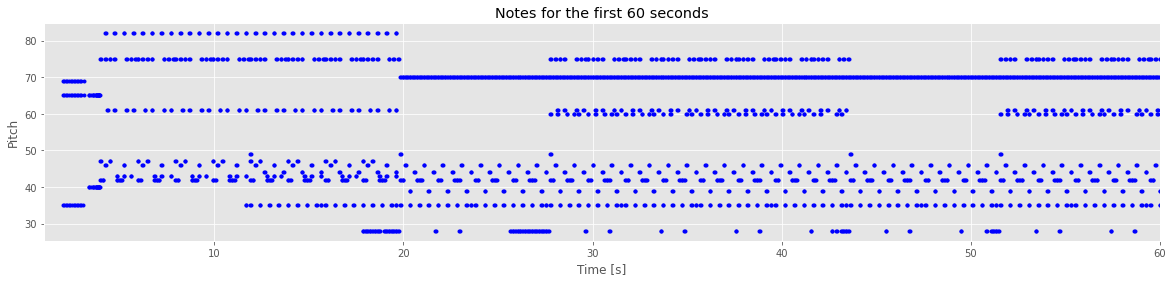

In [25]:
def plot_piano_roll(midi_file, inst="Acoustic Grand Piano", max_time=-1):
    '''La función devuelve las notas en el rango de tiempo especificado.

    La función tiene por objetivo la devolución de una gráfica con las notas
    ploteadas en el intervalo máximo de tiempo especificado. Para el ploteo toma
    el archivo MIDI y el instrumento que se pretende observar.

    Parámetros:
    - midi_file: Path del archivo MIDI a graficar
    - instr: (Opcional) El instrumento del cual se pretende plotear las notas.
             Por defecto, tomará "Acoustic Grand Piano".
    - max_time: (Opcional) Franja de tiempo máximo la cual se pretende
                representar.
    Return:
    Gráfica de notas ploteadas en la franja de tiempo máximo.
    '''
    # Obtenemos el DataFrame a raíz del diccionario ya ordenado
    df =  midi_to_notes(midi_file, instr=inst, end_step=True)

    # Comprobamos valor de max_time
    if max_time > 0:
        title = f'Notes for the first {max_time} seconds'

    elif max_time == -1:
        title = f'Whole track'
        count = len(df['pitch'])

    else:
        title = f'Nope plots because negative time is not possible'
        print("[ERROR] max_time must be in range (0 - inf] or -1")

    # Ploteamos las notas
    plt.figure(figsize=(20, 4))
    plot_pitch = np.stack([df['pitch'], df['pitch']], axis=0)
    plot_start_stop = np.stack([df['start'], df['end']], axis=0)
    plt.plot(plot_start_stop[:,:], plot_pitch[:,:], color="b", marker=".")

    # Imponemos límite de ploteado según el tiempo máximo
    if max_time > 0:
        plt.xlim(df['start'].values.min() - 1, max_time)
    elif max_time == -1:
        plt.xlim(df['start'].values.min() - 1, df['start'].values.max() + 1)
    else:
        plt.xlim(0, 0)

    plt.xlabel('Time [s]')
    plt.ylabel('Pitch')
    _ = plt.title(title)

# Probamos nuestra función modificada
plot_piano_roll(filenames[0], max_time=60)

## 1.3. Procesado de datos
Vamos a procesar los datos ahora. Uno de los ficheros que debemos trabajar ahora es *data_processing_functions.py* del [GitHub](https://github.com/brunnergino/JamBot) del [artículo](https://arxiv.org/pdf/1711.07682.pdf).

En el fichero _data_processing_functions.py_ nos encontramos con la función ```do_all_steps()``` que ejecuta todas las funciones del archivo _.py_ de procesado. Vamos a probar a invocarla para ver su funcionamiento antes de continuar con los siguientes apartados.

> **NOTA**: Cuando nos descargamos el proyecto todos los archivos aparecerán colocados de una manera, con rutas específicas. Como hemos avisado ya, se recomienda no retocar la estructura de los archivos ya que si abrimos _settings.py_ podemos ver como tenemos ya todo configurado para trabajar. En caso de quererse modificar "sí o sí" la estructura el archivo _settings.py_ habrá que retocarlo para que encaje con la nueva estrctura.

In [26]:
# Ejecutamos la función do_all_steps()
dpf.do_all_steps()

changing Tempo
histogramming
data/tempo/
make song histo
shifting midi files
making note indexes
histogramming
data/shifted/tempo/
extracting chords
getting dictionary
converting chords to index sequences
done


Al ejecutarse, podremos pensar que no ha hecho nada pero si volvemos a observar nuestra estructura de datos veremos que se han creado múltiples archivos y carpetas a raíz de la ejecución de la función anterior.

### 1.3.1. Exploración de la función ```change_tempo_folder()```
Para entender que hace la función change_tempo_folder vamos a revisar su código en el archivo data_processing_functions.py:

In [ ]:
#def change_tempo_folder(source_folder,tempo_folder):
#    for path, subdirs, files in os.walk(source_folder):
#        for name in files:
#            _path = path.replace('\\', '/') + '/'
#            _name = name.replace('\\', '/')
#            target_path = tempo_folder+_path[len(source_folder):]
#            if not os.path.exists(target_path):
#                os.makedirs(target_path) 
#            try:
#                mf.change_tempo(_name, _path, target_path)
#            except (ValueError, EOFError, IndexError, OSError, KeyError, ZeroDivisionError, AttributeError) as e:
#                exception_str = 'Unexpected error in ' + name  + ':\n', e, sys.exc_info()[0]
#                print(exception_str)

Se puede observar como lo que hace dicha función es guardar los archivos en una carpeta determinada (en este caso la carpeta _tempo_ en la ruta "_./data_" quedando "_./data/tempo_"), en caso de no existir dicha carpeta la crearía. Pero lo curioso es que llama a otra función llamada ```change_tempo()``` que proviene del otro archivo llamado _midi_functions.py_. Dicha función lo que realiza es cambiar el **bpm** de la canción del archivo MIDI. El [**bpm**](https://blog.storyblocks.com/tutorials/what-are-beats-per-minute-bpm/) sería como la velocidad de una pista de música y puede variar desde ritmos más lentos hasta más rápidos. La traducción de sus siglas son "_Bets Per Minutes_" lo que sería como pulsaciones por minuto.

Para entender los parámetros de entrada de la función necesitamos no solo revisar el archivo _midi_functions.py_ y _data_processing_functions.py_, sino también el archivo _settings.py_ que es donde se encuentran establecidas las variables introducidas en la función como hemos visto en apartados anteriores.

Revisemos el código de ```change_tempo()```:

In [ ]:
#def change_tempo(filename, data_path, target_path):
#    """Rewrite MIDI files"""
#    mid = mido.MidiFile(data_path + filename)
#    new_mid = mido.MidiFile()
#    new_mid.ticks_per_beat = mid.ticks_per_beat
#    for track in mid.tracks:
#        new_track = mido.MidiTrack()
#        for msg in track:
#            new_msg = msg.copy()
#            if new_msg.type == 'set_tempo':
#                new_msg.tempo = 500000

Como se puede observar el tempo (**btm**) que se establece es de 500.000.

Por lo que en definitiva, dicha función creará una carpeta _tempo_ (si es que no existe) en el que introducirá los archivos MIDI con un tempo de 500.000 (**btm**).

### 1.3.2. Creación de más funciones auxiliares
Si hemos ejecutado todo hasta este punto, podemos observar como nuestra estructura de carpetas ha cambiado y ha generado una gran cantidad de carpetas y ficheros nuevos. Vamos a implementar ahora dos funciones para poder recrear la figura 2 del [articulo](https://arxiv.org/pdf/1711.07682.pdf) usando los datos procesados.

Las funciones que crearemos serán:
*   my_save_histo_oct_from_midi_folder
*   my_midi_to_histo_oct

basadas en las funciones ***save_histo_oct_from_midi_folder*** y ***midi_to_histo_oct*** que encontraréis en los ficheros ***midi_functions.py*** y ***data_processing_functions.py***. Ahora las modificaremos para que nos devuelvan datos para dos tipos de histogramas: uno igual a la figura 2 del artículo (apariciones VS pitch) y otro, usando el *histo_oct*, que serán datos para graficar *apariciones VS notas en cualquier octava*, es decir, el número de veces que aparece una nota (sin importar a que octava pertenezca) a lo largo de una canción.

**NOTA**: Es importante entender la estructura de las variables:*
*   pianoroll
*   histo_bar
*   histo_oct

*dentro de la funcion* ***midi_to_histo_oct***

In [27]:
# Usa este vector como labels del segundo gráfico 
notas_en_una_octava = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']

Este apartado será uno de los más complejos de entender dado que deberemos indagar en los archivos y entender exactamente que esta ocurriendo, así que vamos a resumir que son las variables a las que nos enfrentaremos, para ello vamos a copiar las funciones que hemos mencionado y vamos a ver que obtenemos con ellas.

> **NOTA**: Es posible que haya que modificar las funciones dentro de las mismas para que se ejecuten bien acorde a como hemos importado nuestras librerías de funciones.

In [28]:
# Función que guarda los histogramas en la carpeta histo
def my_save_histo_oct_from_midi_folder(tempo_folder,histo_folder):
    print(tempo_folder)
    nfiles=0
    for path, subdirs, files in os.walk(tempo_folder):
        for name in files:
            _path = path.replace('\\', '/') + '/'
            _name = name.replace('\\', '/')
            target_path = histo_folder+_path[len(tempo_folder):]
            if not os.path.exists(target_path):
                os.makedirs(target_path)
            try:
                nfiles+=1
                if nfiles%100==0:
                    print("File #",nfiles,"Current file = ",_path,"/",_name) 
                my_midi_to_histo_oct(samples_per_bar, octave, fs, _name, _path, target_path)
            except (ValueError, EOFError, IndexError, OSError, KeyError, ZeroDivisionError) as e:
                exception_str = 'Unexpected error in ' + name  + ':\n', e, sys.exc_info()[0]
                print(exception_str)

# Función que extrae los pitchs y las notas de nuestros archivos MIDI
# Añadimos un argumento que nos permita la observación de las variables
def my_midi_to_histo_oct(samples_per_bar,octave, fs, name, path, histo_path,
                         variable_to_return=0):
    #print(path + name)
    pianoroll = mf.get_pianoroll(name, path, fs)
    histo_bar = mf.pianoroll_to_histo_bar(pianoroll, samples_per_bar)
    histo_oct = mf.histo_bar_to_histo_oct(histo_bar, octave)
    pickle.dump(histo_oct,open(histo_path + name + '.pickle' , 'wb'))
    
    if variable_to_return == 0:
        return pianoroll

    elif variable_to_return == 1:
        return histo_bar

    elif variable_to_return == 2:
        return histo_oct

La primera función parece tener muy claro su cometido, es alojar los resultados en una carpeta específica (_'data/histo'_).

La segunda función resulta algo más complicada de entender sobre todo sus variables las cuales no están del todo claras en los archivos. Para entenderlo vamos a realizar una pequeña investigación.

> **NOTA**: Las funciones parecen trabajar con rutas y nombres de archivos, por ello, vamos a establecer las rutas de las canciones con el _tempo_ determinado por la función del apartado anterior y a extraer una lista con el nombre de los archivos MIDI antes.

> **NOTA 2**: Hay que trabajar con la carpeta "_data/tempo_" de momento, más adelante se dará una explicación del por qué.

In [29]:
# Obtenemos rutas de archivos
filenames = glob.glob(str("data/tempo/*.mid*"))

# Obtenemos el nombre de todos los archivos MIDI de nuestra BBDD
files = []
for i in range(len(filenames)):
    files.append(filenames[i][11:])

# Establecemos las rutas
path_origin = 'data/tempo/'
path_histo = 'data/histo/'

In [30]:
# Vamos a ver que es pianoroll
my_midi_to_histo_oct(samples_per_bar,octave, fs, files[0], path_origin,
                     path_histo, variable_to_return=0)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [31]:
# Vamos a ver que es histo_bar
my_midi_to_histo_oct(samples_per_bar,octave, fs, files[0], path_origin,
                     path_histo, variable_to_return=1)[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])

In [32]:
# Vamos a ver que es histo_oct
my_midi_to_histo_oct(samples_per_bar,octave, fs, files[0], path_origin,
                     path_histo, variable_to_return=2)[0]

array([ 0.,  1.,  3.,  3.,  5., 10.,  3.,  3.,  5., 10.,  5.,  7.,  2.,
        8., 14., 11., 14., 12., 14., 10., 14., 11.,  4.,  7.,  6.,  8.,
       14., 11., 14., 12., 14., 10., 14., 11., 17., 14., 16., 13., 14.,
       10., 14., 14., 14.,  9., 14., 13., 13., 11., 10., 10., 15., 10.,
       15., 11., 14., 12., 14., 10., 21., 16., 21., 15., 10.,  8.,  9.,
        8.,  7.,  6.,  7.,  8., 16., 11., 15., 10., 16.,  9., 15.,  7.,
       16., 11., 15.,  8., 14., 10., 14., 14., 14., 10., 14., 13., 15.,
       13., 14., 14., 14., 13., 14., 14., 14., 10., 14.,  8., 14.,  9.,
       14.,  9.])

Por lo pronto no tiene mucho sentido los _arrays_ que obtenemos pero, vamos a obtener las longitudes de estos _arrays_ y de los _subarrays_ para que nos demos cuenta que es lo que nos representan.

In [33]:
# Vamos a ver longitud pianoroll
print("Longitud de array de pianoroll:" , len(my_midi_to_histo_oct(
    samples_per_bar,octave, fs, files[0], path_origin, path_histo,
    variable_to_return=0)), "\n")
print("Longitud de subarray de pianoroll:" , len(my_midi_to_histo_oct(
    samples_per_bar,octave, fs, files[0], path_origin, path_histo,
    variable_to_return=0)[2]))

Longitud de array de pianoroll: 128 

Longitud de subarray de pianoroll: 851


In [34]:
# Vamos a ver longitud histo_bar
print("Longitud de array de histo_bar:" , len(my_midi_to_histo_oct(
    samples_per_bar,octave, fs, files[0], path_origin, path_histo,
    variable_to_return=1)), "\n")
print("Longitud de subarray de histo_bar:" , len(my_midi_to_histo_oct(
    samples_per_bar,octave, fs, files[0], path_origin, path_histo,
    variable_to_return=1)[0]))

Longitud de array de histo_bar: 128 

Longitud de subarray de histo_bar: 106


In [35]:
# Vamos a ver longitud histo_oct
print("Longitud de array de histo_oct:" , len(my_midi_to_histo_oct(
    samples_per_bar,octave, fs, files[0], path_origin, path_histo,
    variable_to_return=2)), "\n")
print("Longitud de subarray de histo_oct:" , len(my_midi_to_histo_oct(
    samples_per_bar,octave, fs, files[0], path_origin, path_histo,
    variable_to_return=2)[0]))

Longitud de array de histo_oct: 12 

Longitud de subarray de histo_oct: 106


Podemos ver que la longitud de los _arrays_ son números que nos son familiares, de _pianoroll_ e _histo_bar_ vemos que el valor de 128 es el valor del rango de _pitches_, mientras que con _histo_oct_ 12 nos recuerda a la octava de notas que andamos buscando, luego podemos concluir que cada uno de los subarrays de los arrays obtenidos representarán la aparición de los _pitches_ y de las notas en cada canción. De hecho, si comprobamos a observar la longitud de cada uno de los _subarrays_ de cada canción veremos que este número varia dado que la duración de las mismas es completamente distinto pero lo que es la cantidad de _subarrays_ que hay en todas será el mismo, lo que nos confirma lo que venimos pensando. 

Es decir, por ejemplo para _pianoroll_:

| Pitch 1 | Pitch 2 | Pitch 3 | ... |
| --- | --- | --- | --- | 
| 0 | 1 | 0 | ... | 
| ... | ... | ... | ... |

Por lo que podemos obtener el número de apariciones si realizamos la suma de las filas obtendremos el total de apariciones de los _pitch_ y de las notas (en el caso de usar _histo_oct_). Vamos a modificar la función para que nos de el valor de apariciones de una canción.

> **NOTA**: En la práctica, _pianoroll_ e _histo_bar_ nos darán la misma información sobre los _pitch_.

In [36]:
# Añadimos un argumento que nos permita la observación de las variables
def my_midi_to_histo_oct(samples_per_bar,octave, fs, name, path, histo_path):
    '''La función tiene por objetivo el obtener las notas y las octavas que se
    reproducen en un archivo de sonido MIDI.

    La función recibe la ruta del archivo MIDI y extrae tanto la frecuencia de
    aparición de cada uno de los 128 pitches como la aparición de las 12 notas
    de una octava sin importar la escala.

    Parámetros:
    - samples_per_bar: Parámetro definido en el archivo setting.py
    - octave: Parámetro definido en el archivo settings.py
    - fs: Parámetro definido en el archivo setting.py
    - name: Nombre del archivo MIDI
    - path: Ruta donde se encuentra el archivo MIDI
    - histo_path_ Ruta de las carpeta histo

    Return:
    - notes_in_song: Array con la frecuencia de aparición de los 128 pitchs
    - octave_notes_in_song: Array con la frecuencia de aparición de las notas
    '''
    #print(path + name)
    pianoroll = mf.get_pianoroll(name, path, fs)
    histo_bar = mf.pianoroll_to_histo_bar(pianoroll, samples_per_bar)
    histo_oct = mf.histo_bar_to_histo_oct(histo_bar, octave)
    pickle.dump(histo_oct,open(histo_path + name + '.pickle' , 'wb'))
  
    notes_in_song = []
    for i in range(len(histo_bar)):
        notes_in_song.append(sum(histo_bar[i]))
    
    octave_notes_in_song = []
    for i in range(len(histo_oct)):
        octave_notes_in_song.append(sum(histo_oct[i]))
    
    return notes_in_song, octave_notes_in_song

Una vez que tenemos definida la primera función lo suyo será que dibujemos una serie de gráficas que nos permitan ver la aparición de todas las notas y octavas de todos los archivos a la vez. Para ello modificaremos/crearemos la función que nos permite.

In [37]:
# Función que guarda los histogramas en la carpeta histo
def my_save_histo_oct_from_midi_folder(files, path, histo_path, dataf=False):
    '''La función tiene por objetivo el dibujar dos gráficas en las que se
    representa la ocurrencia de los pitches y las notas. Además devuelve dos
    arrays con esos mismos valores.

    La función devolverá dos arrays, el primero se trata de las ocurrencias de
    los diferentes Pitch (en total 128 diferentes) y el segundo array la cantidad
    de apariciones de las notas sin importar su octava. La función realizará el
    cálculo sobre todos los archivos MIDI alojados en la ruta proporcionada a la
    función.

    Además dibujará dos gráficas que representen esos dos mismos arrays.

    Parámetros:
    - files: Lista con el nombre de los archivos MIDI
    - path: String con la ruta de la carpeta donde se ubican los archivos MIDI
    - histo_path: Ruta de la carpeta histo
    - data: (Opcional) Devolverá dos dataframes en el que se podrá observar por
            cada archivo MIDI (registro) las apariciones de los 128 Pitch y de
            las 12 notas sin importar la octava. Por defecto es False y devolverá
            dos arrays.

    Return:
    - total_pitches: Total de apariciones de los 128 Pitch
    - total_octaves: Aparición del total de notas sin importar la octava

    (Opcionales)
    - df_pitches: Aparición de los 128 Pitch por cada archivo MIDI
    - df_octaves: Aparición de las 12 notas por cada archivo MIDI sin importar
                  la octava en la que se encuentra dicha nota

    Además se dibujarán dos gráficas que representen el array total_pitches y
    total_octaves
    '''
    # Inicialización de las listas para recogida de los datos
    list_pitches = []
    list_octaves = []

    # Obtención de los datos y completado de las listas
    for names in tqdm.tqdm_notebook(files,
                                    desc = "Obtaining pitches and octaves"):
        pitches, octaves = my_midi_to_histo_oct(samples_per_bar,octave,
                                                fs, names, path, histo_path)
        list_pitches.append(pitches)
        list_octaves.append(octaves)

    # Creación de dataframe y recopilación de datos de los Pitch
    df_pitches = pd.DataFrame(list_pitches, columns=range(1,129))
    columns_pitches = df_pitches.columns
    total_pitches = []
    for i in range(len(columns_pitches)):
        total_pitches.append(df_pitches[columns_pitches[i]].sum())

    # Creación de dataframe y recopilación de datos de las notas
    df_octaves = pd.DataFrame(list_octaves, columns=notas_en_una_octava)
    columns_octaves = df_octaves.columns
    total_octaves = []
    for i in range(len(columns_octaves)):
        total_octaves.append(df_octaves[columns_octaves[i]].sum()) 

    # Dibujado de la gráfica de la aparición total de los Pitch
    fig = plt.figure(figsize=[25, 10])
    tick_label = df_pitches.columns
    plt.bar(df_pitches.columns, total_pitches,
            tick_label = df_pitches.columns, width = 0.5)
    plt.xticks(rotation = 90)
    plt.xlabel("Pitch")
    plt.ylabel("Ocurrences")
    plt.title("Occurences vs Pitch")

    plt.show()

    # Dibujado de la gráfica de la aparición total de las notas
    fig = plt.figure(figsize=[25, 8])
    tick_label = df_octaves.columns
    plt.bar(df_octaves.columns, total_octaves, tick_label = df_octaves.columns)
    plt.xlabel("Note")
    plt.ylabel("Ocurrences")
    plt.title("Occurences vs Notes")

    plt.show()

    # Devolución en forma de arrays
    if dataf == False:
        return total_pitches, total_octaves

    # Devolución en forma de DataFrame
    else:
        return df_pitches, df_octaves

Teniendo ya nuestra función lista vamos a probar como va su funcionamiento empleando nuestra base de datos de archivos MIDI.

> **NOTA**: Nos encontraremos con el problema sobre la ruta a emplear para la lectura de los archivos MIDI, ya que si probamos a establecer diferentes rutas en las que podemos encontrar archivos MIDI el resultado de nuestra función difiere bastante de un resultado a otro. Antes de nada hay que aclarar que hemos elaborado el cambio de **bpm** a los archivos y los hemos ubicado en las carpetas _tempo_ por lo que de seguro que deberemos emplear dichos archivos, aunque ahora el problema es si emplear los de la ruta "_data/tempo_" o lo de _"data/shifted/tempo"_. Si observamos bien lo que se realiza en el _paper_ podremos ver que emplean la carpeta "_data/shifted/tempo_" porque ya conocen en que escala están y para simplificar la generación de música emplean los archivos MIDI que ahí se encuentran. Nosotros tendremos un apartado a continuación que nos preguntará por la escala que tenemos en nuestra base de datos por lo que emplearemos la carpeta "_data/tempo_" para observar exactamente que escala se usa por lo general en nuestra base de datos. Supondremos por tanto, que en la carpeta "_data/shifted/tempo_" nos encontraremos la simplificación de los archivos MIDI en una escala muy marcada por esos mismos archivos en la propia carpeta "_data/tempo_", o dicho de otro modo, tendríamos la respuesta

Obtaining pitches and octaves:   0%|          | 0/50 [00:00<?, ?it/s]

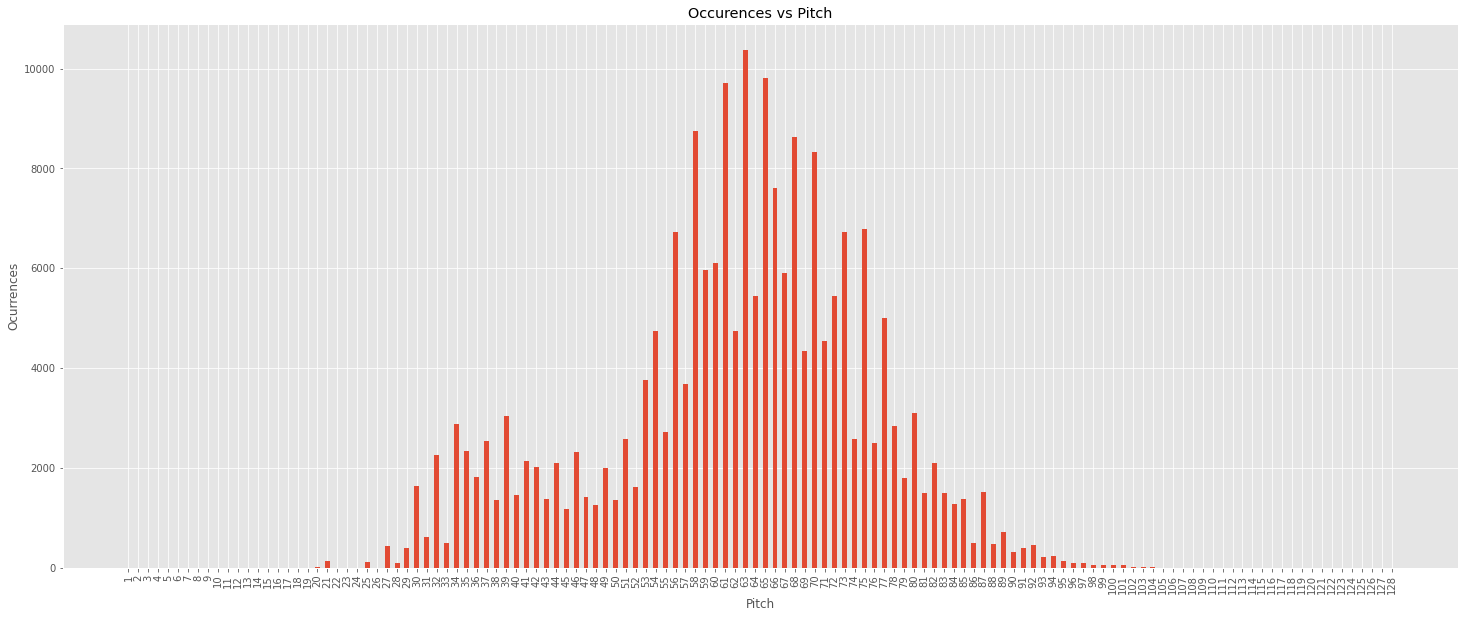

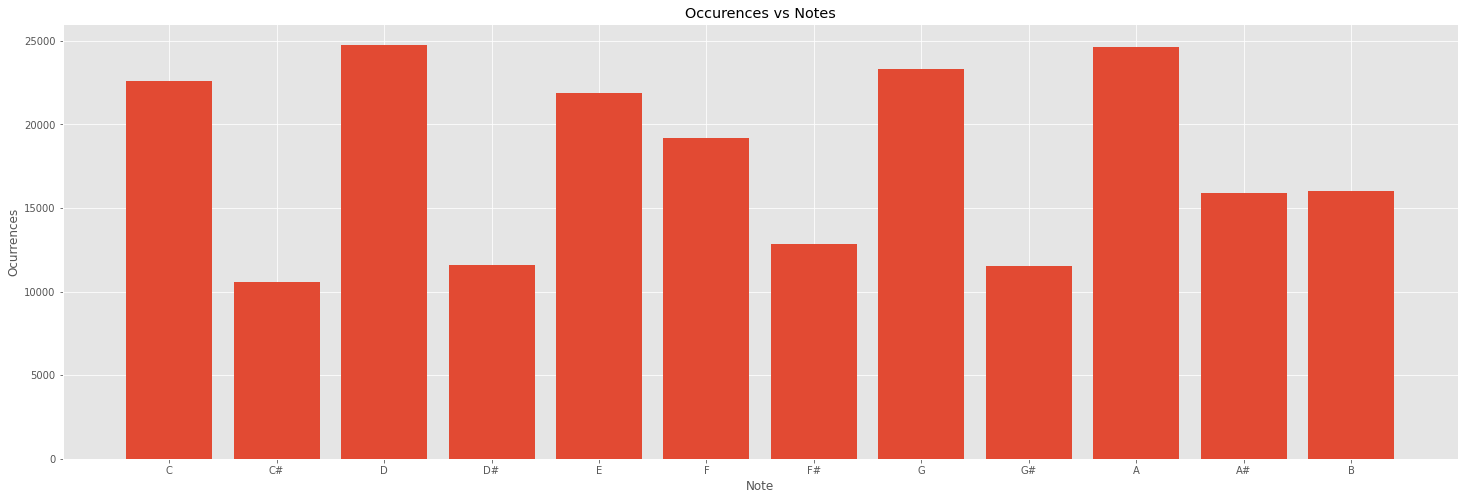

In [38]:
# Establecemos rutas
path_origin = 'data/tempo/'
path_histo = 'data/histo/'

# Obtenemos rutas de archivos
filenames = glob.glob(str("data/tempo/*.mid*"))

# Obtenemos el nombre de todos los archivos MIDI de nuestra BBDD
files = []
for i in range(len(filenames)):
    files.append(filenames[i][11:])

# Probamos la función
histo = my_save_histo_oct_from_midi_folder(files, path_origin, path_histo)

### 1.3.3. ¿Y cuál es la escala musical que tenemos?
Con el gráfico de barras del apartado anterior es muy sencillo ver en que escala se encuentra de forma general los archivos MIDI. Para saber que escala tenemos hay que observar cuales son las **7 notas que aparecen con más frecuencia**, por lo tanto tenemos que por orden de aparición son: D, A, G, C, E, F y B. Es decir, tenemos una de las escalas más famosas y "básicas" en el mundo musical y es la de **C mayor** [(**Do mayor**)](https://es.wikipedia.org/wiki/Do_mayor) la cual no tiene ni bemoles ni sostenidos en su armadura, aunque si que aparezcan de manera individual a lo largo de la canción pues se introducen en muchas ocasiones para sorprender al oyente.

Aunque ¡ojo! la escala de C mayor tiene como escala de tonalidad relativa A menor [(La menor)](https://es.wikipedia.org/wiki/La_menor), es decir, que ambas escalas comparten las mismas notas pero suenan distinto, por lo tanto, diferenciarlas únicamente a simple vista sin escuchar las canciones resulta muy complicado.

Pero lo que las hace diferentes es el orden en el que están dispuestos los elementos y sus relaciones de tonos y medios tonos. Luego esto es lo que nos crea estas sonoridades tan diferentes, el orden que toman los elementos y las relaciones armónicas que se crean entre ellos, las funciones armónicas se modifican y al afectarse las relaciones se cambia el carácter de la escala.

Por lo tanto ¿qué escala tenemos entonces? Pues una **escala C mayor/A menor**, pues ambas son de tonalidad relativas y dado que no nos vamos a poner a escuchar los 50 archivos MIDI, vamos a considerar ambas posibilidades. En este [enlace](https://clasesdeguitarra.com.co/escala-mayor-escala-menor/) podemos escuchar como una canción con las mismas notas puede llegar a sonar alegre (emplea escala mayor) o triste (emplea la relativa menor).

Antes de acabar, vamos a ver como serían los datos _shifted_ para observar como varía la aparición de las notas y veamos si tiene sentido lo que aparece en el _paper_.

Obtaining pitches and octaves:   0%|          | 0/35 [00:00<?, ?it/s]

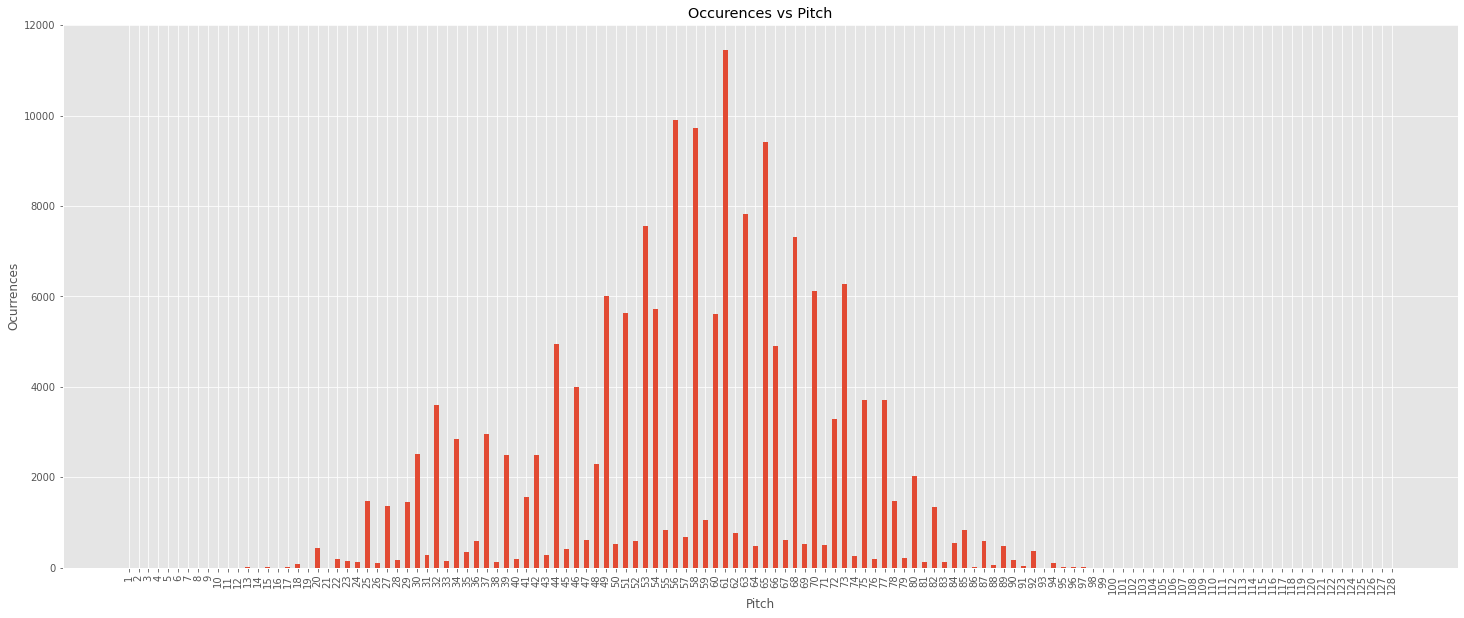

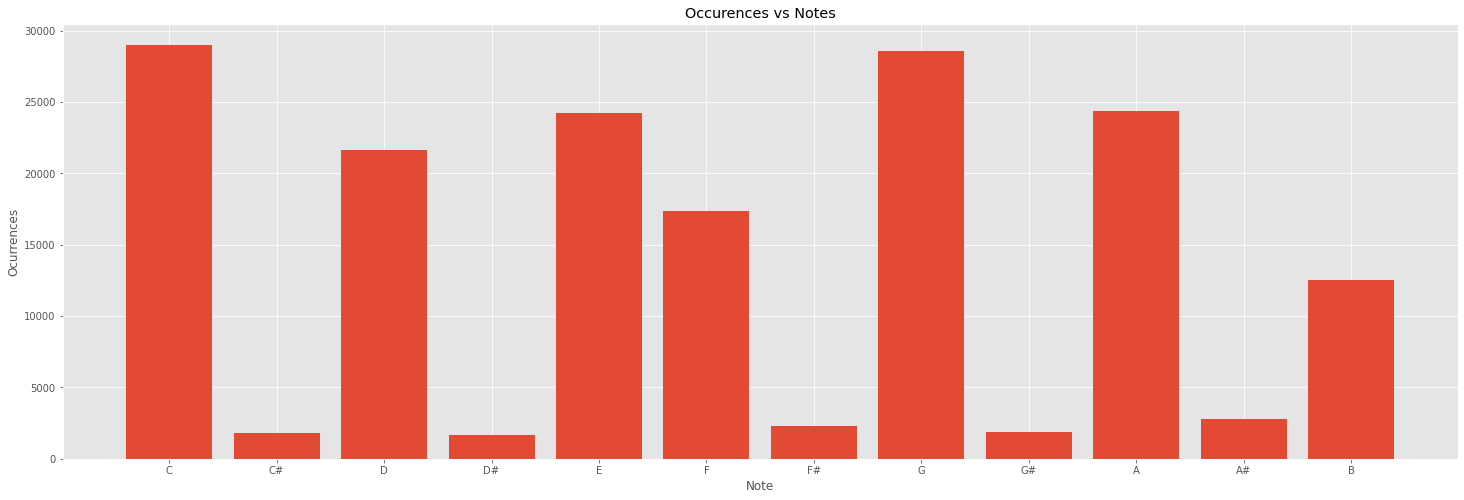

In [39]:
# Establecemos rutas para el dataset shifted
path_origin = 'data/shifted/tempo/'
path_histo = 'data/histo/'

# Obtenemos rutas de archivos
filenames = glob.glob(str("data/shifted/tempo/*.mid*"))

# Obtenemos el nombre de todos los archivos MIDI de nuestra BBDD
files = []
for i in range(len(filenames)):
    files.append(filenames[i][19:])

# Probamos la función
histo = my_save_histo_oct_from_midi_folder(files, path_origin, path_histo)

Ahora es muchísima más clara la evidencia, estamos en una escala **C major/A minor** con total seguridad ya que como podemos ver, las siete notas con mayor aparición son notas típicas de ambas escalas. Además, podemos ver que de los 50 archivos MIDI que tenemos se han empleado 35 para la elaboración de esta última gráfica lo que nos indica que efectivamente, la mayoría de nuestra base de datos son canciones con la escala C major/A minor.

# 2. Red neuronal recurrente - LSTM
El siguiente paso en el artículo es el entrenamiento de una red LSTM para la generación de acordes. Esta parte la haremos con un data set más pequeño y lo compararemos con resultados de entrenamientos previos que se han realizado previamente (esto de regalo para vosotros).

Antes de nada, cargaremos las librerías, que aunque una buena práctica es cargarlas al principio del todo, aquí al ser algo didáctico las cargaremos a continuación.

In [40]:
# Cargamos librerías para la red neuronal
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Activation
from keras.layers import Embedding
from tensorflow.keras.optimizers import RMSprop, Adam
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
import keras.utils
from keras.utils import np_utils
from random import shuffle
import progressbar
import time

<div style="background-color: #ffdf70; border-color: #a52a2a; border-left: 5px solid #a52a2a; padding: 0.5em;">
    
<b>NOTA</b>: Hay que fijarse que se está hablando de <b>acordes</b> por lo que hay que mirar la información relativa al modelo <i>Chord LSTM</i> 

</div>

## 2.1. Cargamos datos : Elaboración de *set* de entrenamiento y *test*
A continuación, siguiendo los pasos del _paper_ vamos a extraer nuestro _dataset_ aunque no emplearemos la totalidad de las canciones, únicamente emplearemos 2000 para el _train_ y unas 500 para el test.

> **NOTA**: Dado que desconocemos totalmente las canciones que tenemos en nuestros datos, vamos a tomar 2000 canciones de _train_ y 500 para test de manera totalmente aleatoria.

In [41]:
# Extraemos las canciones con el modulo pickle
path_dataset = "data/dataset.pkl"
with open(path_dataset, "rb") as f:
    ftrain_set_full, test_set_full= pickle.load(f, encoding='latin-1')

# Tomamos 2000 canciones para train y 500 para set
random.seed(42)
train_set = random.sample(ftrain_set_full, 2000)
test_set = random.sample(test_set_full, 500)

# Observamos la cantidad de elementos para asegurarnos
train_set_size = len(train_set)
test_set_size = len(test_set)

print("El tamaño del set de datos de train es de {} y la de test es de {}"
      .format(train_set_size, test_set_size))

El tamaño del set de datos de train es de 2000 y la de test es de 500


Dichos set de datos representarán la información sobre los acordes de las canciones escogidas.

## 2.2. Modelo con una única capa de *embedding*
### 2.2.1. Recreación del modelo del *paper*
Recrearemos el mismo modelo aunque introduciremos un único cambio que será en el tamaño de la red LSTM, en la que usaremos la mitad de la LSTM del artículo y número de epochs que usaremos 10 en nuestro caso.

Para conocer que parámetros debemos usar debemos dirigirnos a la página 5 del _paper_ en la sección _B. Chord LSTM_. También convendría echar un vistazo al código de [_GitHub_](https://github.com/brunnergino/JamBot/blob/master/chord_lstm_training.py) que nos propone el _paper_.

In [42]:
# Definimos hiperparámetros
batch_size = 1
step_size = 1
epochs = 10

#completar
lstm_size = 128
learning_rate = 10e-5
optimizer = 'Adam'

El siguiente código es para mantener la estructura de carpetas que usan en el artículo ya que hay mucho código que depende de esta estructura:

In [43]:
base_path = 'models/chords/'
model_filetype = '.pickle'

shuffle_train_set = True
bidirectional = False

#Create model dir
fd = {'shifted': shifted, 'lr': learning_rate,
      'emdim': chord_embedding_dim, 'opt': optimizer,
      'bi': bidirectional, 'lstms': lstm_size,
      'trainsize': train_set_size, 'testsize': test_set_size,
      'samples_per_bar': samples_per_bar}
t = str(np.random.randint(1000,9999))
model_name = t+ '-Shifted_%(shifted)s_Lr_%(lr)s_EmDim_%(emdim)s_opt_%(opt)s_bi_%(bi)s_lstmsize_%(lstms)s_trainsize_%(trainsize)s_testsize_%(testsize)s_samples_per_bar%(samples_per_bar)s' % fd
model_path = base_path + model_name + '/'
if not os.path.exists(model_path):
    os.makedirs(model_path)

### 2.2.2. Compilación del modelo
Como hemos comentado antes, es recomendable visitar el código del modelo _LSTM_ para los acordes. En el siguiente [enlace](https://github.com/brunnergino/JamBot/blob/master/chord_lstm_training.py) podemos encontrarlo para su copiado. 

In [44]:
# Copiado del modelo y modificado del mismo en caso de necesitarse
print('creating model...')
model = Sequential()
model.add(Embedding(num_chords, chord_embedding_dim,
                    input_length=step_size, name="embedding",
                    batch_input_shape=(batch_size,step_size)))
# model.add(Embedding(num_chords, chord_embedding_dim, input_length=step_size))

# if bidirectional: model.add(Bidirectional(LSTM(lstm_size, stateful=True)))
# else: model.add(LSTM(lstm_size, stateful=True))
model.add(LSTM(lstm_size, stateful=True))
model.add(Dense(num_chords))
model.add(Activation('softmax'))
if optimizer == 'Adam':
    optimizer = Adam(lr=learning_rate)
# Lo dejamos pues en el enunciado lo importan
elif optimizer == 'RMS':
    optimizer = RMSprop(lr=learning_rate)
loss = 'categorical_crossentropy'
print("compiling model")
model.compile(optimizer, loss)

# Vemos un resumen del modelo
model.summary()

creating model...
compiling model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (1, 1, 10)                500       
                                                                 
 lstm (LSTM)                 (1, 128)                  71168     
                                                                 
 dense (Dense)               (1, 50)                   6450      
                                                                 
 activation (Activation)     (1, 50)                   0         
                                                                 
Total params: 78,118
Trainable params: 78,118
Non-trainable params: 0
_________________________________________________________________


## 2.3. Entrenamiento de la red neuronal
Siguiendo el código orginal del artículo donde se define la arquitectura de la LSTM para los acordes hay 3 funciones más:
*   test()
*   train()
*   save_params()

que nos serán de ayuda para el entrenamiento, testeo y para guardar los datos sobre el modelo entrenado. Guardaremos el valor de la ***loss*** tanto para test como para train cada 500 canciones, por lo que tendremos más de un punto por epoch. Modifica, si es necesario, las funciones *test()* y *train()* para que los ficheros de *total_test* y *total_train* dejen constancia de la epoch a la que pertenecen, esto te ayudará al graficar los datos más adelante.

Añade, antes de cada función una cabecera explicando brevemente lo que ésta hace.

> **NOTA**: Conviene antes de entrenar comprobar que todas las funciones elaboradas estén correctamente escritas ya que nos llevaremos sino la sorpresa de haber perdido tiempo entrenando para que finalmente nos de error alguna función.

In [45]:
# Variables para nuestras funciones
# Array para la recogida del valor de las épocas
epoch_array = []

# Array para la recogida del valor de loss en la fase de test
total_test_loss_array = []

# Array para la recogida del valor de loss en la fase de train
total_train_loss_array = []

# Valor del loss en test
total_test_loss = 0

# True: Muestra la evolución de la gráfica loss en train y test
show_plot = False

# True: Guarda en formato .png la gráfica loss de train y test
save_plot = True

# Establece el paso para la realización del testeo y entrenamiento
test_step = 500

# Variables adicionales para las funciones
verbose = False
save_step = 1

# Funciones test(), train() y save_params() modificadas

# Función que ejecuta la evaluación del modelo RNN ya entrenado con datos test
def test():
    '''Función test del modelo RNN.

    La función elaborará el testeo del modelo RNN entrenado y tendrá por objetivo
    el emitir dos archivos en formato pickle con la información de las épocas,
    el valor de loss con el conjunto test y train por separado.

    También ploteará una gráfica con la evolución del loss tanto de test como de
    train y tendrá la posibilidad de guardar dicho gráfico en formato .png.

    Return:
    - total_test_loss_array.pickle: Archivo que contiene dos arrays, uno sobre
                                    las épocas y otro sobre el valor del loss en
                                    la fase de test. En formato .pickle.
    - total_test_loss_array.pickle: Archivo que contiene dos arrays, uno sobre
                                    las épocas y otro sobre el valor del loss en
                                    la fase de train. En formato .pickle.
    - plot.png: (Opcional) Gráfica sobre la evolución del loss en la fase de
                entrenamiento y test.
    '''
    print('\nTesting:')
    total_test_loss = 0

    # Evaluación del modelo entrenado
    bar = progressbar.ProgressBar(maxval=test_set_size, redirect_stdout=False)
    for i, test_song in enumerate(test_set):
        # IMPORTANTE: Hay que convertir nuestras listas a np.array
        X_test = np.array(test_song[:-1])
        Y_test = np_utils.to_categorical(test_song[1:], num_classes=num_chords)
        loss = model.evaluate(X_test, Y_test,
                              batch_size=batch_size, verbose=verbose)
        # Reseteo de los parámetros guardados (las RNN poseen "memoria")
        model.reset_states()
        total_test_loss += loss
        bar.update(i+1)

    # Recopilación de datos sobre loss del conjunto test
    total_test_loss_array.append(total_test_loss/test_set_size)
    print('\nTotal test loss: ', total_test_loss/test_set_size)
    print('-'*50)

    # Ploteo de la gráfica loss
    plt.figure(figsize=[15, 8])
    plt.plot(total_test_loss_array, 'b-', label='test loss')
    plt.plot(total_train_loss_array, 'r-', label='train loss')
    #plt.legend()
    plt.ylabel(model_path)
    #plt.axis([0, 50, 3, 5])
    plt.grid()

    # Guardado o no del gráfico y ploteo del gráfico o no
    if show_plot: plt.show()
    if save_plot: plt.savefig(model_path+'plot.png')

    # Añadimos la información sobre las épocas en un doble array
    data_test = [epoch_array, total_test_loss_array]
    data_train = [epoch_array, total_train_loss_array]

    # Guardado en archivos .pickle de los datos recopilados
    pickle.dump(data_test,
                open(model_path+'total_test_loss_array.pickle', 'wb'))
    pickle.dump(data_train,
                open(model_path+'total_train_loss_array.pickle', 'wb'))

# Función que ejecuta el entrenamiento del modelo RNN
def train():
    '''Función que entrena modelo RNN Chord LSTM
 
    La función tiene por objetivo el entrenamiento del modelo RNN para los
    acordes de una canción en un archivo con formato MIDI. 
    También ejecutará la función test() que evaluará y guardará información sobre
    este paso.

    Return:
    - model_EpochX_X.pickle: Guardará el estado del modelo en cada una de las 
                             épocas del entrenamiento.
    '''
    print('training model...')
    total_train_loss = 0

    # Entrenamiento del modelo
    for e in range(1, epochs+1):
        print('Epoch ', e, 'of ', epochs, 'Epochs\nTraining:')
        if shuffle_train_set:
            shuffle(train_set)
        bar = progressbar.ProgressBar(maxval=train_set_size)
        for i, song in enumerate(train_set):
            #bar.start()
            # IMPORTANTE: Hay que convertir nuestras listas a np.array
            X = np.array(song[:-1])
            Y = np_utils.to_categorical(song[1:], num_classes=num_chords)
            hist = model.fit(X, Y, batch_size=batch_size,
                             shuffle=False, verbose=verbose)
            # Reseteo de los parámetros guardados (las RNN poseen "memoria")
            model.reset_states()
            bar.update(i+1)
            #print(hist.history)
            total_train_loss += hist.history['loss'][0]
            if (i+1)%test_step is 0:
                # Agregamos el epoch para dejar constancia
                epoch = (e-1)+(i+1)/len(train_set)
                # Completamos epoch_array
                epoch_array.append(epoch)
                total_train_loss = total_train_loss/test_step
                # Completamos total_train_loss_array
                total_train_loss_array.append(total_train_loss)
                # Ejecución de la función test() para la evaluación del modelo
                test()
                total_train_loss = 0
                
        # Guardado del estado del modelo
        if e%save_step is 0:
            print('saving model')
            model_save_path = model_path + 'model_' + 'Epoch' + str(e) + '_' + str(
                i+1) + model_filetype
            model.save(model_save_path)


def save_params():
    '''Función que guarda los hiperparámetros de nuestro modelo RNN

    La función guarda los datos de los hiperparámetros de nuestro modelo RNN en
    un archivo con formato .txt.
    '''
    with open(model_path + 'params.txt', "w") as text_file:
        text_file.write("epochs: %s" % epochs + '\n')
        text_file.write("train_set_size: %s" % train_set_size + '\n')
        text_file.write("test_set_size: %s" % test_set_size + '\n')
        text_file.write("lstm_size: %s" % lstm_size + '\n')
        text_file.write("embedding_dim: %s" % chord_embedding_dim + '\n')
        text_file.write("learning_rate: %s" % learning_rate + '\n')
        #text_file.write("save_step: %s" % save_step + '\n')
        text_file.write("shuffle_train_set: %s" % shuffle_train_set + '\n')
        text_file.write("test_step: %s" % test_step + '\n')
        text_file.write("bidirectional: %s" % bidirectional + '\n')
        text_file.write("num_chords: %s" % num_chords + '\n')
        text_file.write("chord_n: %s" % chord_n + '\n')

Ahora lo interesante será entender que es el elemento X e Y (_label_) de nuestras funciones por lo que vamos a responder una serie de preguntas que deberíamos de plantearnos:

* **¿Qué representa cada elemento de X en la función de train()?** Cada elemento representa un acorde de la canción que contiene el archivo MIDI. Se toman todos menos el último acorde.

* **¿Qué se está usando como _label_ para cada elemento de X?** Lo que se esta tratando como _label_ son todos los acordes menos el primero de la canción en cuestión. Es decir, en Y (_label_) tendríamos todos los acordes menos uno, y lo que pretendemos es predecir el acorde que falta a continuación del primero que si lo tendríamos en _X_.

* **Justifica el uso de _categorical_crossentropy_ como función de loss.** Como es habitual, cuando tenemos que determinar una clase (un problema de clasificación) empleabamos dicha función de pérdida por ser la que mejor funciona. En este caso, si nos fijamos _label_ lo convertimos en una clase, es decir, en una categoría, y al final lo que pretendemos con nuestra red neuronal es clasificar y obtener el último acorde. Por lo tanto, empleamos dicha función de pérdida por ser un problema de clasificación categórico.

* **¿Qué crees que está aprendiendo la red?** A raíz de las cuestiones anteriores podemos terminar diciendo que lo que predecimos son acordes acorde a los acordes que introducimos en el modelo. No obstante, si nos fijamos en profundidad en el código vemos que en la variable _Y_ de nuestras funciones se emplea la función ```np_utils.to_categorical()``` que trata de buscar un índice en un diccionario ([word2vec](https://en.wikipedia.org/wiki/Word2vec)) . Por lo tanto, al final lo que estaremos aprendiendo es realmente los indices al diccionario de acordes, no los acordes per se, aunque la red escupirá un acorde.

Para resumirlo con otras palabras, lo que tratamos de realizar con nuestra red neuronal es que aprenda a generar música (nuevos acordes) a partir de una serie de acordes que servirán como "inicio" de la canción que vamos a completar y por lo tanto con los datos X de _train_ en la red recurrente estamos aprendiendo/memorizando como debe ser la secuencia de acordes. Y con los datos Y de _train_ queremos probar si la secuencia de acordes generados son similares y de no serlo, que la red se ajusto para minimizar el error.

Bueno vamos al lío y entrenemos esta red neuronal como se merece aunque ahora si que sí, es hora de tomarse un café, la red tardará en un orden de horas hasta estar lista. Para aumentar la potencia de cálculo es recomendable activar la _GPU_.

In [46]:
# Entrenamiento del modelo
with tf.device('/gpu:0'): # Forzamos por si acaso al uso de GPU
    print("saving params")
    save_params()
    print("starting training..")
    train()

Output hidden; open in https://colab.research.google.com to view.

Después de varias horas, tenemos nuestro modelo entrenado con todos los archivos guardados correctamente.

## 2.4. Comparamos modelos
En este último paso compararemos diferentes modelos. En la carpeta *models/chords* encontrarás los datos (en un formato similar al generado anteriormente) del entrenamiento de modelos similares con otros parámetros:

1.   carpeta: 2717-Shifted_True_...
2.   carpeta: 5102-Shifted_True_...

Ahora es turno de comprobar que tan bueno es nuestro modelo comparándolo con los modelos pre-entrenados que se proporcionan. Para ello vamos a elaborar dos gráficas (una para _train_ y otra para test) y observar las diferencias.

Antes vamos a observar que configuración se han seguido en los modelos.

* **Indica los parámetros de cada uno de los 3 modelos (el que habéis entrenado y los 2 que os hemos dado)**

In [49]:
# Extracción de la información del modelo 2717
path_2717 = "models/chords/2717-Shifted_True_Lr_1e-05_EmDim_10_opt_Adam_bi_False_lstmsize_256_trainsize_2000_testsize_500_samples_per_bar8/params_0.txt"
conf_2717 = pd.read_csv(path_2717, sep=" ", header=None, names=["Params", "Model 2717"])

# Extracción de la información del modelo 5012
path_5102 = "models/chords/5102-Shifted_True_Lr_1e-05_EmDim_10_opt_Adam_bi_False_lstmsize_256_trainsize_4000_testsize_1000_samples_per_bar8/params_0.txt"
conf_5102 = pd.read_csv(path_5102, sep=" ", header=None, names=["Params", "Model 5102"])

# Extracción de la información de nuestro modelo
path_our = "models/chords/9237-Shifted_True_Lr_0.0001_EmDim_10_opt_Adam_bi_False_lstmsize_128_trainsize_2000_testsize_500_samples_per_bar8/params.txt"
conf_our = pd.read_csv(path_our, sep=" ", header=None, names=["Params", "Our Model (9237)"])

# En caso de querer observar todos a la vez
merged_inner_1_2 = pd.merge(left=conf_2717, right=conf_5102, left_on='Params',
                            right_on='Params')
all_models = pd.merge(left=merged_inner_1_2, right=conf_our, left_on='Params',
                      right_on='Params')
# Observamos todos los modelos
all_models

,Params,Model 2717,Model 5102,Our Model (9237)
0,epochs:,10,20,10
1,train_set_size:,2000,4000,2000
2,test_set_size:,500,1000,500
3,lstm_size:,256,256,128
4,embedding_dim:,10,10,10
5,learning_rate:,1e-05,1e-05,0.0001
6,shuffle_train_set:,True,True,True
7,test_step:,500,1000,500
8,bidirectional:,False,False,False
9,num_chords:,50,50,50


Ahora vamos a observar sus gráficas gracias a los archivos _pickle_ que se han generado de todos los modelos.

In [50]:
# Obtenemos path de cada modelo
path_2717 = "models/chords/2717-Shifted_True_Lr_1e-05_EmDim_10_opt_Adam_bi_False_lstmsize_256_trainsize_2000_testsize_500_samples_per_bar8/"
path_5102 = "models/chords/5102-Shifted_True_Lr_1e-05_EmDim_10_opt_Adam_bi_False_lstmsize_256_trainsize_4000_testsize_1000_samples_per_bar8/"
path_our = "models/chords/9237-Shifted_True_Lr_0.0001_EmDim_10_opt_Adam_bi_False_lstmsize_128_trainsize_2000_testsize_500_samples_per_bar8/"

# Extraemos los datos
path_data_train = "total_train_loss_array.pickle"
path_data_test = "total_test_loss_array.pickle"

# Datos train
with open(path_2717+path_data_train, "rb") as f:
    epoch_array_2717, loss_train_array_2717= pickle.load(f, encoding='latin-1')
with open(path_5102+path_data_train, "rb") as f:
    epoch_array_5102, loss_train_array_5102= pickle.load(f, encoding='latin-1')
with open(path_our+path_data_train, "rb") as f:
    epoch_array_our, loss_train_array_our= pickle.load(f, encoding='latin-1')

# Datos test
with open(path_2717+path_data_test, "rb") as f:
    epoch_array_2717, loss_test_array_2717= pickle.load(f, encoding='latin-1')
with open(path_5102+path_data_test, "rb") as f:
    epoch_array_5102, loss_test_array_5102= pickle.load(f, encoding='latin-1')
with open(path_our+path_data_test, "rb") as f:
    epoch_array_our_test, loss_test_array_our= pickle.load(f, encoding='latin-1')

> **NOTA**: El valor del array de test y train es exactamente el mismo dado que poseen las mismas épocas, por lo que a la hora de dibujar las gráficas nos daría lo mismo emplear uno que otro. Sino el siguiente _chunk_ de código nos lo confirmará.

In [51]:
# Comprobación que las épocas de train y test son iguales
epoch_array_our == epoch_array_our_test

True

In [52]:
# Plot del loss en train y test
def plot_prediction(model_1, epochs_1, train_1, test_1, model_2, epochs_2,
                    train_2, test_2, model_3, epochs_3, train_3, test_3):
    '''Función que permite imprimir por pantalla la gráfica de la evolución del
    valor de loss en función del número de épocas.

    La función presenta por pantalla la gráfica de evolución de la pérdida en 
    función de las épocas que se quiera observar.

    Argumentos:
    - model_1: Nombre del modelo 1
    - epochs_1: Array con las épocas que se quiere representar del modelo 1
    - train_1: Array con los valores loss del entrenamiento del modelo 1
    - test_1: Array con los valores loss del test del modelo 1
    - model_2: Nombre del modelo 2
    - epochs_2: Array con las épocas que se quiere representar del modelo 2
    - train_2: Array con los valores loss del entrenamiento del modelo 2
    - test_2: Array con los valores loss del test del modelo 2
    - model_3: Nombre del modelo 3
    - epochs_3: Array con las épocas que se quiere representar del modelo 3
    - train_4: Array con los valores loss del entrenamiento del modelo 3
    - test_4: Array con los valores loss del test del modelo 3

    Return:
    La función no presenta un return al uso sino el ploteo de tres gráficas
    '''
    try:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))
        fig.suptitle("Loss in train and test run", fontsize=16)
      
        ax1.plot(epochs_1, train_1, label="train")
        ax1.plot(epochs_1, test_1, label="test")
        ax1.set_title(model_1)
        ax1.set_xlabel("n_epoch")
        ax1.set_ylabel("loss")
        ax1.legend(loc="upper right")
      
        ax2.plot(epochs_2, train_2, label="train")
        ax2.plot(epochs_2, test_2, label="test")
        ax2.set_title(model_2)
        ax2.set_xlabel("n_epoch")
        ax2.set_ylabel("loss")
        ax2.legend(loc="upper right")

        ax3.plot(epochs_3, train_3, label="train")
        ax3.plot(epochs_3, test_3, label="test")
        ax3.set_title(model_3)
        ax3.set_xlabel("n_epoch")
        ax3.set_ylabel("loss")
        ax3.legend(loc="upper right")

        plt.show()
    except:
        print("El tamaño de los array de las epochs y de loss_train/test no son" +
              " iguales. Por favor, compruebe el tamaño de los arrays.")

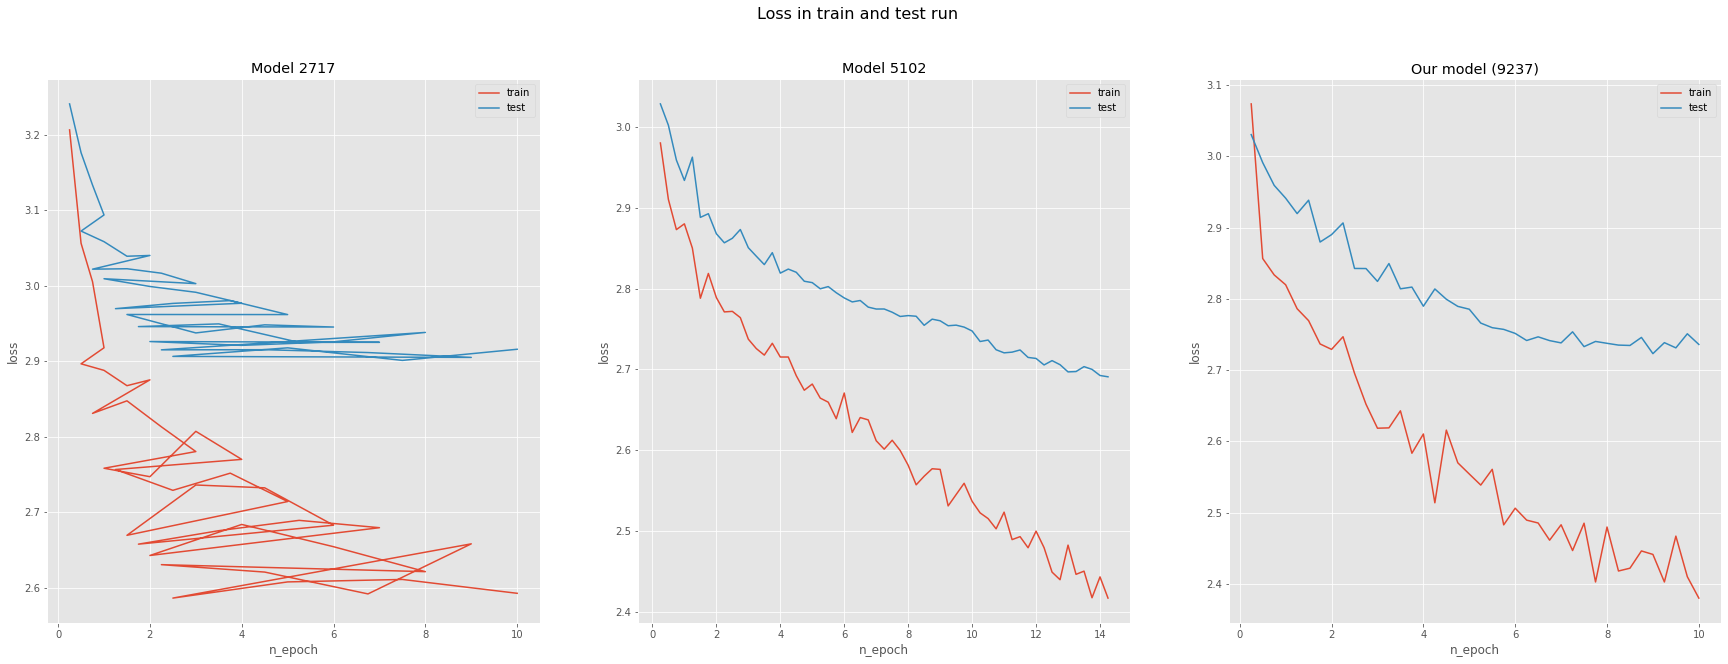

In [53]:
# Probamos nuestra función de ploteo
plot_prediction("Model 2717", epoch_array_2717,
                loss_train_array_2717, loss_test_array_2717,
                "Model 5102", epoch_array_5102,
                loss_train_array_5102, loss_test_array_5102,
                "Our model (9237)", epoch_array_our,
                loss_train_array_our, loss_test_array_our,)

Vemos que el modelo 2717 debe de tener alguna confusión con el valor de las épocas, por suerte son las mismas que nuestro modelo por lo que podremos hacer el cambio de su array de épocas por el de nuestro modelo para observar mejor que evolución sigue en la realidad.

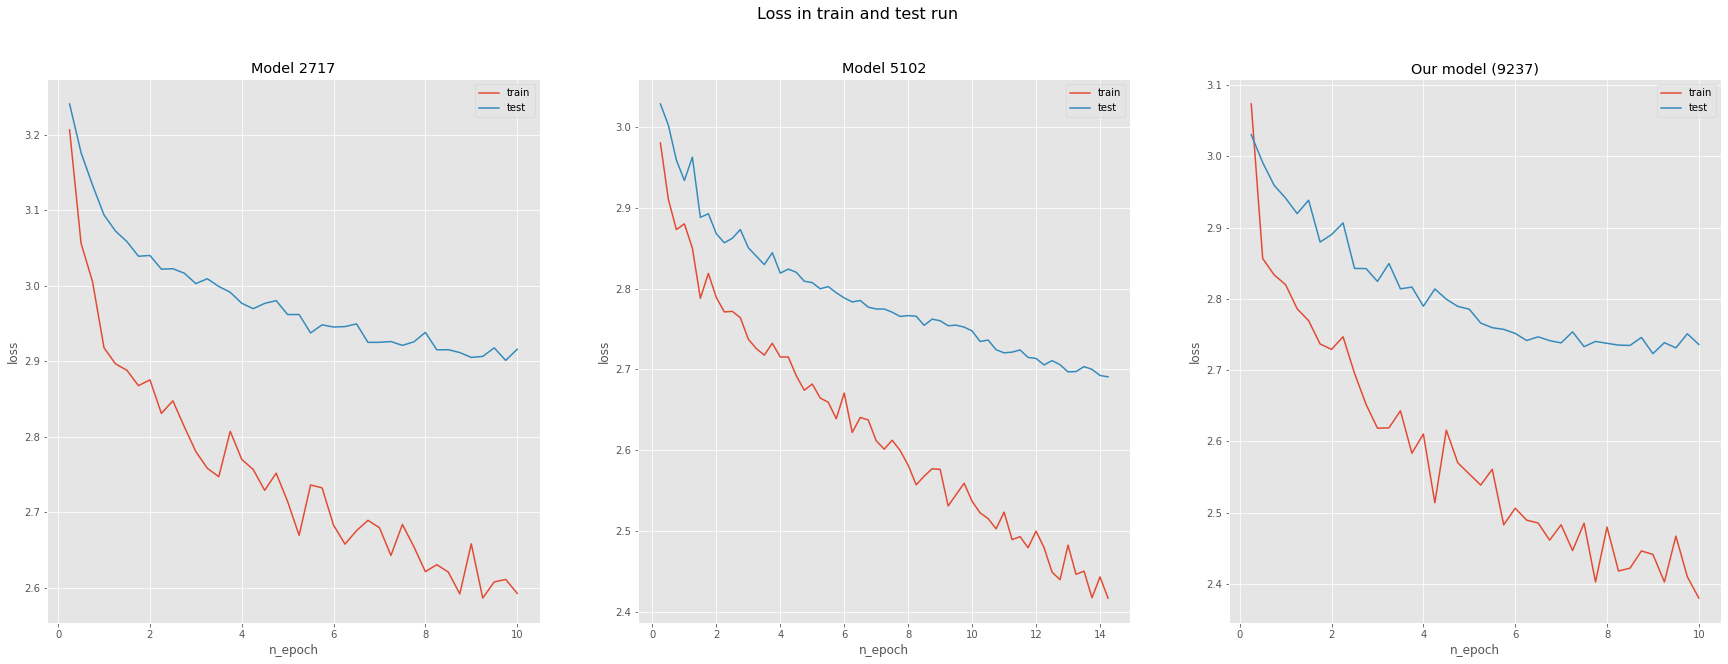

In [54]:
plot_prediction("Model 2717", epoch_array_our,
                loss_train_array_2717, loss_test_array_2717,
                "Model 5102", epoch_array_5102,
                loss_train_array_5102, loss_test_array_5102,
                "Our model (9237)", epoch_array_our,
                loss_train_array_our, loss_test_array_our,)

Ahora sí, mucho mejor.

Viendo las gráficas, podemos dar respuestas a una serie de preguntas que nos deberíamos plantear:

* **¿Qué set de parámetros ha dado la mejor performance?** El mejor resultado parece ser el del modelo 5102 donde se puede apreciar que el error test es el menor de los tres modelos además de poseer una curva _loss_ en test con una mayor pendiente, similar a la de _train_ y sin tanta tanta variación en su trayectoria. Un error que nos puede llegar a pensar que nuestro modelo es mejor que el modelo 5102 es que la curva de _loss_ para _train_ tiene un menor error para la última época, esto puede llevarnos a tomar el modelo erróneo ya que lo que buscamos no es que en la fase de entrenamiento el error sea muy bajo (que también) sino que el modelo haya generalizado bien y en la fase test, que son casos nuevos no explorados por el modelo, el error sea lo más pequeño posible. Además, también hay que observar observar la trayectoria que siguen ambas rectas (test y _train_) ya que si la trayectoria de ambas es muy similar significará que estamos obteniendo un buen rendimiento, pero sin embargo, si tenemos que ambas curvas toman caminos muy diferentes (que normalmente aparecerá que la curva _train_ continuará decreciendo su valor de _loss_ mientras que la curva de test comienza a incrementar el valor de _loss_) diremos que el rendimiento es pésimo (a lo que añadiremos que se esta produciendo _overfitting_).


* **¿Se aprecia overfitting en alguno de los modelos?** Buscamos que el error en la fase test sea menor que en la fase de entrenamiento, esto es lo contrario a lo que pretendemos cuando observamos el _accuracy_ donde lo que se busca es mayor puntuación en la fase test que en la de _train_. La razón de buscar esta situación es para comprobar que nuestro modelo ha sabido generalizar bien con los datos de entrenamiento, es decir, que la predicción con nuevos datos sea lo más precisa posible e incluso mejor. Es por ello, que en la teoría, todo modelo debería tener un _loss_ menor en la fase de test que en la fase de entrenamiento dado que si tenemos un bajo _loss_ en _train_ y un alto _loss_ en test podremos decir que el modelo se ha especializado mucho en los datos de entrenamiento y no ha sabido generalizar el problema. Dicho esto, podemos llegar a la conclusión que nuestro modelo posee algo de _overfitting_ ya que el _loss_ en test es mayor que en _train_, aunque es realmente pequeño si comparamos los valores de la última _epoch_. No obstante, muchas veces conseguir que esto no pase es realmente difícil y menos si no se cuenta con la potencia de computación adecuada para estudiar multitud de combinación de hiperparámetros como de una gran cantidad de datos para entrenar nuestro modelo, así que en estos casos, como en el nuestro, lo que tratamos siempre de buscar es que la curva _loss_ test y _loss_ _train_ no se distancien mucho para asimilar que ese pequeño sobreentrenamiento puede "despreciarse".


Con respecto a la última pregunta hay que tener mucho cuidado con el incluir más o menos épocas ya que otro síntoma de sobreajuste sería que a medida que aumentamos las épocas la curva de _loss_ de _train_ continúa decreciendo mientras que la curva de _loss_ de test comienza a incrementarse. En ese punto es cuando podemos asegurar que se esta produciendo _overfitting_. En nuestro modelo parece que si continuasemos la curva _loss_ de test terminaría por incrementarse, por lo que podríamos llegar a determinar que se esta produciendo un _overfitting_ en toda regla.

# 3. Análisis de la capa *embedding*
Vamos a recrear la figura 8 del [artítulo](https://arxiv.org/pdf/1711.07682.pdf) con la red que hemos entrenado y la que mejor resultados nos da.

In [55]:
from keras.models import load_model
import keras
from keras import backend as K

## 3.1. Carga de los modelos entrenados y observación de los *embeddings*
Ahora tocará cargar el modelo que hemos entrenado en el apartado anterior y el que hemos considerado como el que tenía mejor rendimiento (modelo 5102). Para ello tendremos que señalar a _keras_ en su función ```load_model()``` la ruta del modelo entrenado en la última época que lo consideraremos como el modelo con mayor ajuste en ambos casos. Conviene visitar la página de [TensorFlow](https://www.tensorflow.org/guide/keras/save_and_serialize?hl=es-419) para tener más información sobre la función ```load_model()``` ya que como podremos comprobar, la carpeta que habrá que leer es la carpeta en formato _.pickle_, es decir, deberemos cargar la directamente con la función de _TensorFlow_.

In [56]:
# Obtenemos ruta de nuestro modelos en su última época
my_model_path = "models/chords/9237-Shifted_True_Lr_0.0001_EmDim_10_opt_Adam_bi_False_lstmsize_128_trainsize_2000_testsize_500_samples_per_bar8/model_Epoch10_2000.pickle"
bp_model_path = "models/chords/5102-Shifted_True_Lr_1e-05_EmDim_10_opt_Adam_bi_False_lstmsize_256_trainsize_4000_testsize_1000_samples_per_bar8/model_Epoch14_4000.pickle"
# Cargamos los modelos con load_model
my_model = load_model(my_model_path)
bp_model = load_model(bp_model_path)

Ahora crearemos, para cada modelo, un nuevo modelo para los *embedding*. Para hacer esto, deberás crear un nuevo modelo cuya entrada sea igual a la entrada de los modelos originales y la salida sea el layer *"embedding"*. Esto lo puedes hacer usando la función ```get_layer()``` del modelo.

Vamos a elaborar un modelo para los _embedding_ de cada uno de los modelos anteriormente cargados. Para ello, se recomienda visitar el [_GitHub_](https://github.com/brunnergino/JamBot/blob/master/chord_model.py) de nuevo para encontrar un ejemplo de como se podría hacer. Además, visitar la página de [Keras](https://keras.io/api/models/model/) para entender un poco más sobre el funcionamiento de la función ```get_layer()```.

> **NOTA**: No se nos dice nada en lo referente a resetear los modelos, es por ello que no se hará la llamada a la función ```reset_states()```.

In [57]:
# Elaboramos modelos embedding aplicando el código de GitHub
my_model_output = K.function([my_model.layers[0].input], [my_model.layers[0].output])
bp_model_output = K.function([bp_model.layers[0].input], [bp_model.layers[0].output])

# Our model
my_embed_model = keras.models.Model(inputs=my_model.input,
                                    outputs=my_model.get_layer(
                                        name="embedding").output,
                                    name="my_embedding_model")
# Model 5102
bp_embed_model = keras.models.Model(inputs=bp_model.input,
                                    outputs=bp_model.get_layer(
                                        name="embedding").output,
                                    name="bp_embedding_model")

# Compilamos los modelos
my_embed_model.compile(optimizer, loss)
bp_embed_model.compile(optimizer, loss)

# Observamos nuestro modelo
my_embed_model.summary()

Model: "my_embedding_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_input (InputLayer  [(1, 1)]                 0         
 )                                                               
                                                                 
 embedding (Embedding)       (1, 1, 10)                500       
                                                                 
Total params: 500
Trainable params: 500
Non-trainable params: 0
_________________________________________________________________


In [58]:
# Observamos modelo 5102
bp_embed_model.summary()

Model: "bp_embedding_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_input (InputLayer  [(1, 1)]                 0         
 )                                                               
                                                                 
 embedding (Embedding)       (1, 1, 10)                500       
                                                                 
Total params: 500
Trainable params: 500
Non-trainable params: 0
_________________________________________________________________


El modelo de embedding recibe un acorde y devuelve un vector de 10 dimensiones con el embedding para cada acorde. Vamos a calcular estos vectores con cada uno de los modelos de embedding.

Recordando la pregunta que contestamos en el apartado **2.3.2** sobre **¿Qué crees que está aprendiendo la red??** terminamos diciendo lo siguiente:

_"...si nos fijamos en profundidad en el código vemos que en la variable Y de nuestras funciones se emplea la función ```np_utils.to_categorical()``` que trata de buscar un índice en un diccionario ([word2vec](https://en.wikipedia.org/wiki/Word2vec)) . Por lo tanto, al final lo que estaremos aprendiendo es realmente los indices al diccionario de acordes, no los acordes per se, aunque la red escupirá un acorde."_

Es decir, estamos aprendiendo realmente el índice de un diccionario, por lo que tendría sentido esperar que si introdujeramos un número (que representaría un arcorde) en nuestros modelos recibieramos un vector. Veamos una prueba.

In [59]:
# Observamos que es lo que nos devuelve el modelo
vector_model = bp_embed_model(0)
vector_model

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([-0.36108005, -0.43124926,  0.39179945,  0.37809446,  0.4058383 ,
       -0.40012142, -0.45527804,  0.51227486,  0.35345533,  0.56977504],
      dtype=float32)>

In [60]:
# Observamos la dimensión de dicho vector
vector_model.shape

TensorShape([10])

Efectivamente, obtenemos un vector de dimensión 10, lo que nos es muy familiar ¿no?. Revisamos los resumenes de nuestros modelos del apartado anterior veremos que la dimensión del output realmente será un elemento de tres dimensiones 1x1x10, siendo 10 el tamaño de nuestro vector. En el siguiente apartado vamos a ver como podemos eliminar la tercera dimensión con un _squeeze_.

Aun a pesar de saber que deberemos realizar la recopilación de 50 vectores porque en el siguiente apartado lo veremos, vamos a tratar de entender por qué. Vamos a fijarnos en los archivos que tenemos en la carpeta _data_, más específicamente en los dos archivos que tienen por nombre _index_dict.pickle_ y _index_dict_shifted.pickle_.

In [61]:
# Realizamos observación de dichos archivos
index_dict_view = pickle.load(open("data/index_dict.pickle", 'rb'))
index_shifted_dict_view = pickle.load(open("data/index_dict_shifted.pickle",
                                           'rb'))
index_dict_view

{0: '<unk>',
 1: (2, 7, 11),
 2: (0, 4, 7),
 3: (2, 6, 9),
 4: (0, 5, 9),
 5: (),
 6: (1, 4, 9),
 7: (0, 4, 9),
 8: (4, 8, 11),
 9: (2, 5, 10),
 10: (4, 7, 11),
 11: (2, 5, 9),
 12: (3, 7, 10),
 13: (2, 7, 9),
 14: (4, 9, 11),
 15: (2, 6, 11),
 16: (3, 6, 11),
 17: (2, 4, 9),
 18: (2, 7, 10),
 19: (4, 7, 9),
 20: (0, 3, 8),
 21: (1, 5, 8),
 22: (0, 2, 7),
 23: (1, 6, 10),
 24: (1, 6, 9),
 25: (0, 2, 9),
 26: (0, 5, 7),
 27: (0, 3, 7),
 28: (0, 7, 9),
 29: (1, 4, 8),
 30: (0, 7, 10),
 31: (0, 5, 10),
 32: (0, 5, 8),
 33: (6, 9, 11),
 34: (2, 4, 11),
 35: (3, 8, 11),
 36: (2, 5, 7),
 37: (5, 7, 10),
 38: (2, 9, 11),
 39: (4, 6, 11),
 40: (2, 4, 7),
 41: (0, 7, 11),
 42: (1, 5, 10),
 43: (4, 6, 9),
 44: (7, 9, 11),
 45: (5, 8, 10),
 46: (3, 5, 10),
 47: (3, 6, 8),
 48: (5, 9, 10),
 49: (3, 6, 10),
 50: (5, 7, 9),
 51: (4, 8, 9),
 52: (3, 8, 10),
 53: (0, 2, 5),
 54: (1, 6, 8),
 55: (0, 4, 5),
 56: (0, 3, 5),
 57: (4, 5, 9),
 58: (1, 3, 8),
 59: (2, 6, 7),
 60: (1, 6, 11),
 61: (1, 8, 11),

In [62]:
index_shifted_dict_view

{0: '<unk>',
 1: (0, 4, 7),
 2: (0, 4, 9),
 3: (2, 7, 11),
 4: (0, 5, 9),
 5: (2, 5, 9),
 6: (4, 7, 11),
 7: (0, 5, 7),
 8: (0, 2, 7),
 9: (2, 7, 9),
 10: (0, 7, 9),
 11: (5, 7, 9),
 12: (0, 7, 11),
 13: (0, 2, 9),
 14: (4, 7, 9),
 15: (2, 5, 7),
 16: (),
 17: (0, 4, 5),
 18: (5, 7, 11),
 19: (1, 4, 9),
 20: (2, 4, 9),
 21: (4, 5, 9),
 22: (2, 4, 11),
 23: (4, 9, 11),
 24: (4, 5, 7),
 25: (2, 4, 7),
 26: (2, 6, 9),
 27: (0, 2, 5),
 28: (7, 9, 11),
 29: (0, 2, 4),
 30: (0, 9, 11),
 31: (2, 7, 10),
 32: (5, 7, 10),
 33: (0, 4, 8),
 34: (0, 4, 11),
 35: (2, 4, 5),
 36: (2, 9, 11),
 37: (3, 7, 10),
 38: (5, 9, 10),
 39: (2, 5, 10),
 40: (4, 8, 11),
 41: (5, 8, 9),
 42: (0, 2, 11),
 43: (2, 6, 7),
 44: (7, 9),
 45: (6, 9, 11),
 46: (4, 5, 11),
 47: (1, 6, 9),
 48: (4, 6, 9),
 49: (2, 6, 11)}

Como podemos apreciar en nuestra pequeña investigación, parece que lo que hemos mencionado sobre el diccionario tiene todo el sentido. En la visualización de los archivos podemos ver como un número (índice) representa un acorde compuesto por tres notas (del 0 al 11 que correspondería la posición de la nota en la lista de la variable ```notas_en_una_octava``` que nombramos anteriormente, o dicho de otro modo, representan las notas de una octava).

Si releemos el _paper_ y recordando lo que mencionamos en el apartado **1.3.3** tiene sentido que trabajemos con el diccionario _shifted_ dado que vamos a centrarnos en una escala _C major/A minor_. Por lo tanto, parecer que deberemos recopilar 50 tensores para cada modelo. Aplicaremos un _loop_ y almacenaremos dichos tensores.

In [63]:
# Creamos lista de "50 acordes"
list_chords = list(range(50))

# Recopilación de los vectores para nuestro modelo
my_tensor_predict = my_embed_model.predict(list_chords)

# Recopilación de los vectores para el modelo 5102
bp_tensor_predict = bp_embed_model.predict(list_chords)

Por último, vamos a ver que dimensión tienen dichos tensores.

In [64]:
# Observamos dimensión de un vector
bp_tensor_predict.shape

(50, 1, 10)

Vemos que tenemos una dimensión que nos va a entorpecer así que vamos a eliminarla.

El objetivo será eliminar la dimensión 1 de los vectores que hemos obtenido en el paso anterior, para ello aplicaremos ```squeeze()``` de [numpy](https://numpy.org/doc/stable/reference/generated/numpy.squeeze.html).

In [65]:
# Ejecutamos el squeeze en ambos vectores
my_tensor = np.squeeze(my_tensor_predict, axis=1)
bp_tensor = np.squeeze(bp_tensor_predict, axis=1)

print("La nueva dimensión de los vectores será {}".format(my_tensor.shape))

La nueva dimensión de los vectores será (50, 10)


Finalmente hemos convertido nuestros tensores de dimensión (50,1,10) en tensores de dimensión (50,10).

## 3.2. Análisis PCA
Para acabar con el análisis de las capas *embedding* vamos a realizar uno de los pasos más típicos en minería de datos, el análisis PCA para reducir las dimensiones de los vectores resultantes y poder realizar una gráfica en 2D con los mismos.

In [66]:
# Cargamos librerías para el análisis PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [67]:
# Escalado de los tensores
standard = StandardScaler()
my_tensor_st = standard.fit_transform(my_tensor)
bp_tensor_st = standard.fit_transform(bp_tensor)

# Aplicamos PCA
pca = PCA(n_components=2)
my_tensor_pca = pca.fit_transform(my_tensor_st)
bp_tensor_pca = pca.fit_transform(bp_tensor_st)

# Chequeamos un registro
my_tensor_pca[0]

array([-0.06369062,  1.8888253 ], dtype=float32)

Para facilitar el tratamiento de los datos vamos a elaborar un _DataFrame_ de _pandas_ que además nos añadirá como índice números del [0-49] con lo que la correspondencia con el valor de los índices del diccionario de acordes nos podrá ser muy útil.

In [68]:
# Elaboración de un DataFrame con los valores pca
my_tensor_pca_df = pd.DataFrame(my_tensor_pca, columns=["X", "Y"])
bp_tensor_pca_df = pd.DataFrame(bp_tensor_pca, columns=["X", "Y"])

# Vemos primeros registros de un DataFrame
my_tensor_pca_df.head(2)

,X,Y
0,-0.063691,1.888825
1,-0.676612,-0.721760


Vamos a probar primer a visualizar los datos representados en una gráfica en 2D para ver como han quedado después de las transformaciones de estandarización y PCA.

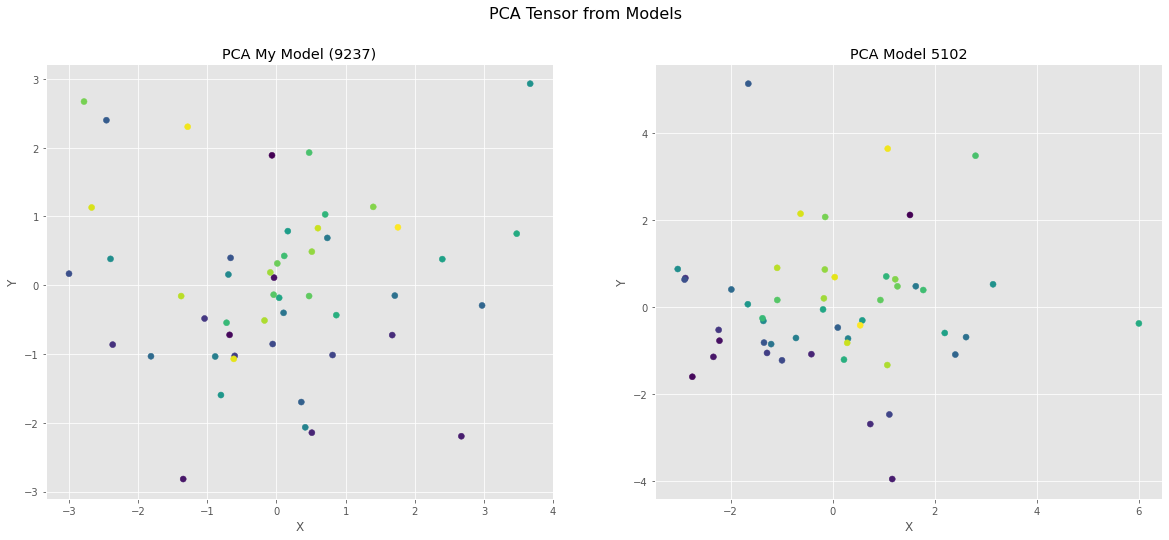

In [70]:
# Dibujamos gráficas sin añadir aun acordes a los puntos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle("PCA Tensor from Models", fontsize=16)
      
ax1.scatter(my_tensor_pca_df["X"], my_tensor_pca_df["Y"],
            c=my_tensor_pca_df.index)
ax1.set_title("PCA My Model (9237)")
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
      
ax2.scatter(bp_tensor_pca_df["X"], bp_tensor_pca_df["Y"],
            c=bp_tensor_pca_df.index)
ax2.set_title("PCA Model 5102")
ax2.set_xlabel("X")
ax2.set_ylabel("Y")

plt.show()

Ahora que tenemos una idea en "limpio" de como se aparecen los puntos en una gráfica, vamos a añadirles a cada uno los acordes tal y como aparecen en la figura 8 del _paper_ (página 7). 

Como tenemos el índice en nuestro _DataFrame_ de PCA va a ser muy sencillo ligarlo con la siguiente función que nos proporcionará los acordes y las notas que componen cada uno de los mismos.

In [72]:
def get_chord_dict():
    chord_to_index = pickle.load(open(dict_path + chord_dict_name, 'rb'))
    index_to_chord = pickle.load(open(dict_path + index_dict_name, 'rb'))
    return chord_to_index, index_to_chord

chord_to_index, idx_2_chord = get_chord_dict()

In [73]:
# Observación de los elementos que se han extraido
idx_2_chord

{0: '<unk>',
 1: (0, 4, 7),
 2: (0, 4, 9),
 3: (2, 7, 11),
 4: (0, 5, 9),
 5: (2, 5, 9),
 6: (4, 7, 11),
 7: (0, 5, 7),
 8: (0, 2, 7),
 9: (2, 7, 9),
 10: (0, 7, 9),
 11: (5, 7, 9),
 12: (0, 7, 11),
 13: (0, 2, 9),
 14: (4, 7, 9),
 15: (2, 5, 7),
 16: (),
 17: (0, 4, 5),
 18: (5, 7, 11),
 19: (1, 4, 9),
 20: (2, 4, 9),
 21: (4, 5, 9),
 22: (2, 4, 11),
 23: (4, 9, 11),
 24: (4, 5, 7),
 25: (2, 4, 7),
 26: (2, 6, 9),
 27: (0, 2, 5),
 28: (7, 9, 11),
 29: (0, 2, 4),
 30: (0, 9, 11),
 31: (2, 7, 10),
 32: (5, 7, 10),
 33: (0, 4, 8),
 34: (0, 4, 11),
 35: (2, 4, 5),
 36: (2, 9, 11),
 37: (3, 7, 10),
 38: (5, 9, 10),
 39: (2, 5, 10),
 40: (4, 8, 11),
 41: (5, 8, 9),
 42: (0, 2, 11),
 43: (2, 6, 7),
 44: (7, 9),
 45: (6, 9, 11),
 46: (4, 5, 11),
 47: (1, 6, 9),
 48: (4, 6, 9),
 49: (2, 6, 11)}

Como podemos ver, la variable ```idx_2_chord``` es la que nos responde sobre el acorde que tenemos en cuestión ya que es un diccionario ordenado. Tenemos las notas en forma numérica, pero ya sabemos lo que representan, así que lo que vamos a realizar es un _DataFrame_ con esta misma variable para poder trabajar más cómodos y obtener la traducción al nombre de la nota en específico.

In [74]:
# Emplearemos un bucle que nos haga la transformación del las tuplas
list_total = []
for i in range(len(idx_2_chord)):
    if type(idx_2_chord[i]) == tuple:
        list_notes = []
        for j in range(len(idx_2_chord[i])):
            list_notes.append(notas_en_una_octava[idx_2_chord[i][j]])
        list_total.append(list_notes)
    else:
        list_total.append(idx_2_chord[i])

Ahora añadiremos esta información a nuestros _dataset_ con los tensores de cada modelo.

In [75]:
# Agregamos la información a nuestros DataFrames
my_tensor_pca_df["Notes_Chord"] = list_total
my_tensor_pca_df["Value_Notes"] = idx_2_chord.values()

bp_tensor_pca_df["Notes_Chord"] = list_total
bp_tensor_pca_df["Value_Notes"] = idx_2_chord.values()

Finalmente, tenemos toda la información condensada en estos _DataFrames_ y podremos trabajar las gráficas de una manera muy cómoda.

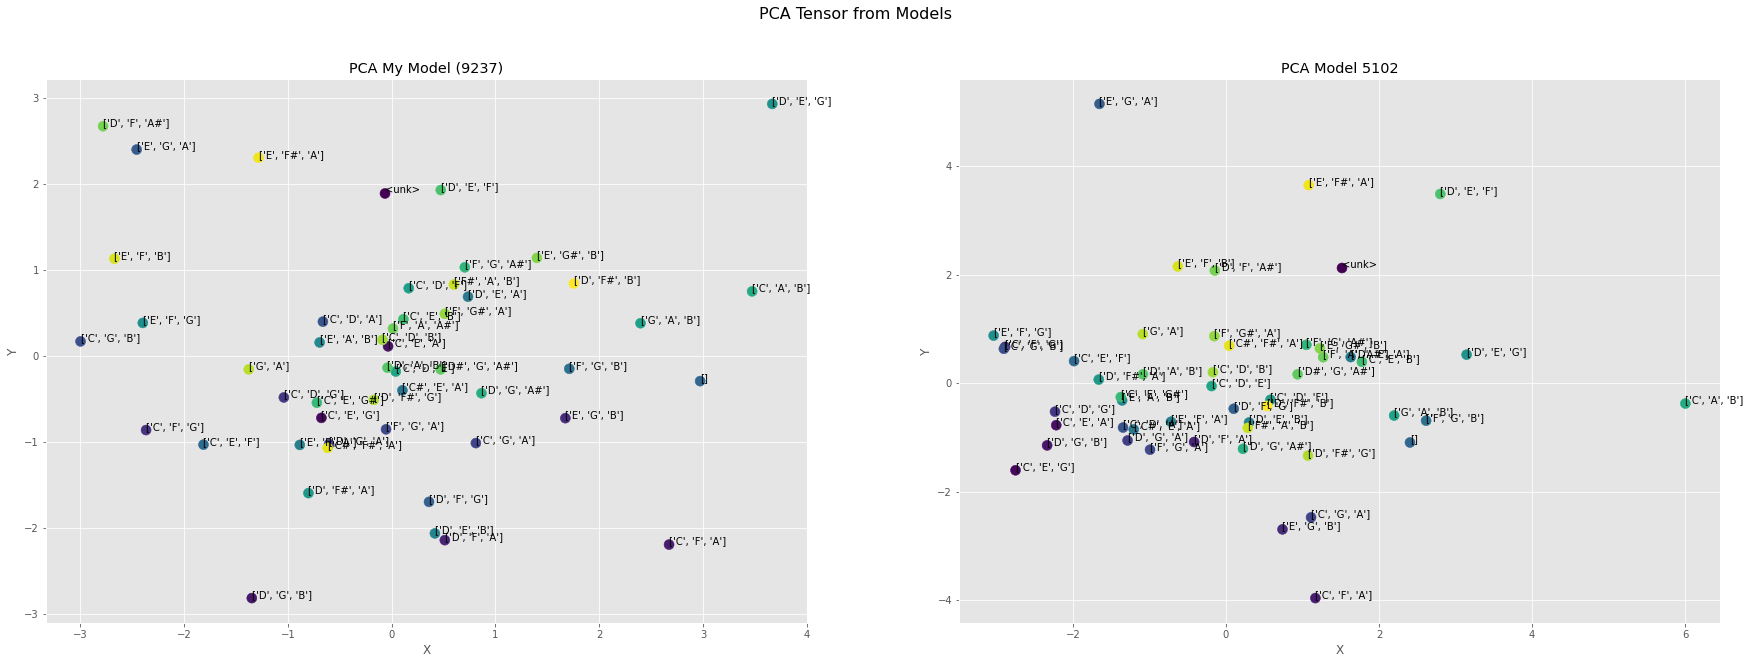

In [77]:
# Dibujamos gráficas sin añadir aun acordes a los puntos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))
fig.suptitle("PCA Tensor from Models", fontsize=16)
      
ax1.scatter(my_tensor_pca_df["X"], my_tensor_pca_df["Y"], s=100,
            c=my_tensor_pca_df.index)
ax1.set_title("PCA My Model (9237)")
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
# Añadimos las anotaciones sobre cada punto
for i, label in enumerate(my_tensor_pca_df["Notes_Chord"]):
    ax1.annotate(label, (my_tensor_pca_df["X"][i], my_tensor_pca_df["Y"][i]))

ax2.scatter(bp_tensor_pca_df["X"], bp_tensor_pca_df["Y"], s=100,
            c=my_tensor_pca_df.index)
ax2.set_title("PCA Model 5102")
ax2.set_xlabel("X")
ax2.set_ylabel("Y")
# Añadimos las anotaciones sobre cada punto
for i, label in enumerate(bp_tensor_pca_df["Notes_Chord"]):
    ax2.annotate(label, (bp_tensor_pca_df["X"][i], bp_tensor_pca_df["Y"][i]))


plt.show()

Ahora daremos respuesta a una de las preguntas que tenemos que tener en mente: **¿Observas el efecto word2vect en las gráficas?**.

Para dar respuesta vamos a dar la definición de lo que es _"word2vect"_ según _TensorFlow_ y _Wikipedia_: _**"word2vec no es un algoritmo singular, sino una familia de arquitecturas modelo y optimizaciones que se pueden usar para aprender incrustaciones de palabras a partir de grandes conjuntos de datos."**_
_**"Una vez entrenado, dicho modelo puede detectar palabras sinónimas o sugerir palabras adicionales para una frase sin terminar. Como su nombre indica, Word2vec representa cada palabra distinta con una lista particular de números llamada vector. Los vectores están escogidos cuidadosamente de forma que una función matemática sencilla (la similitud coseno entre los vectores) indica el nivel de la similitud semántica entre las palabras representada por dichos vectores."**_

En nuestro caso, no son palabras sino acordes, no obstante, es igual de válida la definición dado que lo que tratamos de realizar es entrenar una red neuronal que nos complete una canción con una serie de acordes. Lo interesante de esta red reside sobre todo en la capa _embedding_ que visitando este [enlace](http://projector.tensorflow.org) podremos ver como _TensorFlow_ nos muestra como se vería una capa _embedding_ en dos o tres dimensiones para los problemas más típicos en redes neuronales (_Minist with images_, Word2Vec 10K, _Iris dataset_...). Esto es muy interesante ya que si hemos visitado la página veremos como se alojan las posibilidades de clasificación en una determinada región del espacio donde parece que los puntos guardan un cierto parecido.

Si nos fijamos en nuestro caso puede que nos resulte complicado si no sabemos mucho sobre teoría musical, no obstante, si que podemos observar un poco sobre el efecto _word2vec_ cuando vemos que los puntos que están casi superpuestos tienen en común dos notas, lo que representaría que el estilo musical basado en esos acordes es muy similar y por tanto, encontramos la gran potencia de esta red, determinando el estilo musical con una serie de acordes podemos completar la pieza con otros acordes generados por la red que encajen en ese mismo estilo. De hecho, si nos fijamos en el acorde ["C", "E", "A"] (en la coordenada (-2.749027,-1.601997 en el modelo 5102) y tenemos la oportunidad de tocarlas en un piano, veremos que si también tocamos los acordes que posee a su alrededor parecen tener el mismo "estilo" musical muy similar, de hecho, esos acordes tienen el mismo estilo que la canción ["_Grief and Sorrow_"](https://www.youtube.com/watch?v=GWv1f9KglHM) de la banda sonora del anime Naruto, y no solo queda ahí, sino que tiene la [misma](https://musescore.com/18923628926/grief-and-sorrow) escala musical.

Para terminar, es recomendable leer de nuevo el apartado _A. Chord LSTM_ en las páginas 6 y 7 del _paper_ para completar aun más la explicación dada.

Otra cuestión a resolver podría ser ¿cómo están relacionados los acordes con las distancias mínimas entre estos?. Es decir, la idea será obtener la distancia de los puntos unos a otros para hacernos una idea de cuales son más cercanos y cuales son más lejanos, de este modo, podremos ver que acordes son "más" parecidos y cuales son completamente distinos. Para esta tarea, elaboraremos una función que nos calcule la distancia euclídea (consideraremos esta distancia dado que no se nos expresa lo contrario y es la más sencilla) entre dos puntos.

> **NOTA**: Para el cálculo de la distancia euclidea podemos emplear varias funciones e incluso calcularla nosotros a mano. Vamos a emplear la función ```euclidean()``` de _scipy_ en nuestro caso.

In [78]:
# Definimos la función que nos ayudará a buscar la distancia
def obtain_distances(dataset, num_chords=20):
    ''' La función tiene por objetivo el cálculo de las distancias entre
    los puntos de un dataset que tenga por columnas X e Y.

    La función toma un dataset el cual posee dos columnas de coordenadas y realiza
    el cálculo de la distancia euclídea entre los diferentes registros del dataset

    Parámetros:
    - dataset:  Dataset el cual contiene los registros con variables X e Y
    - num_chords: (Opcional) Número de elementos que a los que se les quiere
                  conocer la distancia entre ellos. Por defecto el número es 20
                  además se tomarán los primeros registros

    Return:
    La función devolverá una lista con todas las distancia calculadas
    '''
    # Creamos una lista con todos los puntos del PCA en forma de listas
    list_total = []
    for j in range(len(bp_tensor_pca_df[:num_chords])):
        list_point = []
        list_point.append(bp_tensor_pca_df.X[j])
        list_point.append(bp_tensor_pca_df.Y[j])
        list_total.append(list_point)
      
    all_values = []
    for i in range(len(list_total)):
        all_values.append([])
        for j in range(len(list_total)):
            dist = euclidean(list_total[i], list_total[j])
            all_values[i].append(dist)

    return all_values

Ahora que tenemos la función vamos a guardar estas distancias en un _DataFrame_ para hacer una representación en un _heatmap_.

In [79]:
# Obtenemos distancias y las guardamos en una lista de listas
distances_chords_myM = obtain_distances(my_tensor_pca_df)
distances_chords_5102 = obtain_distances(bp_tensor_pca_df)

# Obtenemos dos DataFrames
distance_matrix_myM = pd.DataFrame(distances_chords_myM,
                                   columns=my_tensor_pca_df["Value_Notes"][:20],
                                   index=my_tensor_pca_df["Value_Notes"][:20])

distance_matrix_5102 = pd.DataFrame(distances_chords_5102,
                                   columns=bp_tensor_pca_df["Value_Notes"][:20],
                                   index=bp_tensor_pca_df["Value_Notes"][:20])

# Veamos algunos registros de esta matriz
distance_matrix_myM.head(2)

Value_Notes,<unk>,"(0, 4, 7)","(0, 4, 9)","(2, 7, 11)","(0, 5, 9)","(2, 5, 9)","(4, 7, 11)","(0, 5, 7)","(0, 2, 7)","(2, 7, 9)","(0, 7, 9)","(5, 7, 9)","(0, 7, 11)","(0, 2, 9)","(4, 7, 9)","(2, 5, 7)",(),"(0, 4, 5)","(5, 7, 11)","(1, 4, 9)"
Value_Notes,,,,,,,,,,,,,,,,,,,,
<unk>,0.000000,5.662835,4.724139,5.051038,6.090154,3.742474,4.876739,4.634206,4.588999,4.235527,4.611306,4.182225,4.660611,4.100916,4.378154,2.953455,3.334746,3.897751,3.019593,4.030240
"(0, 4, 7)",5.662835,0.000000,0.986080,0.616708,4.570187,2.390206,3.653275,2.277181,1.195979,1.563035,3.956798,1.797279,2.242890,1.609762,6.836219,3.067442,5.178082,2.150918,5.440632,1.717592


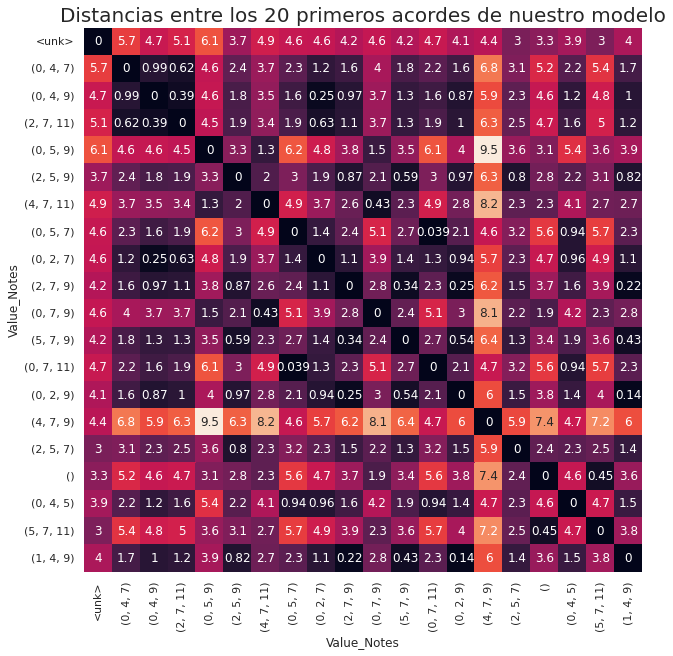

In [80]:
# Dibujamos el heatmap de las distancias de nuestro modelo
plt.figure(figsize=(10, 10))
sns.set(font_scale=1)
sns.heatmap(distance_matrix_myM, annot=True, cbar=False)
plt.title("Distancias entre los 20 primeros acordes de nuestro modelo",
          fontsize=20)

plt.show()

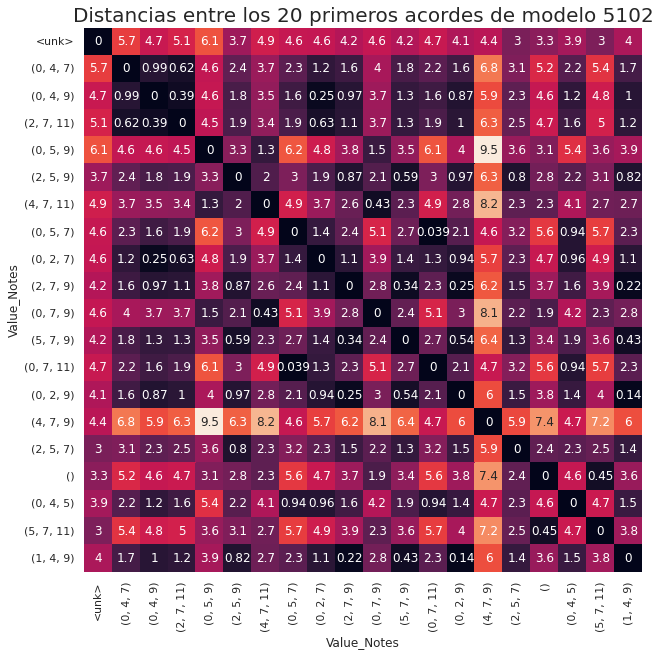

In [81]:
# Dibujamos el heatmap de las distancias del modelo 5102
plt.figure(figsize=(10, 10))
sns.set(font_scale=1)
sns.heatmap(distance_matrix_5102, annot=True, cbar=False)
plt.title("Distancias entre los 20 primeros acordes de modelo 5102",
          fontsize=20)

plt.show()

Con el mapa de calor podemos de un simple vistazo cuales son las distancias entre los acordes.

Para la obtención de las 10 distancias mínimas por ejemplo, sin embargo, tendremos un gran problema, ya que tendremos un _DataFrame_ con distancias repetidas. Para ello, vamos a elaborar otra función que nos de un dataframe algo más sencillo.


> **NOTA**: Vamos ahora a tratar de obtener la distancia empleando una fórmula casera, con el módulo _math_.

In [82]:
# Función que tomará los valores necesarios
def get_distances(dataset, num_chords=20):
    '''Función que permite obtener distancias entre pares de acordes

    La función tiene el objetivo de devolver una lista con la distancia entre dos
    acordes en función de los puntos en el espacio generados por el análisis PCA.

    Parámetros:
    - dataset:  Dataset el cual contiene los registros con variables X e Y
    - num_chords: (Opcional) Número de elementos que a los que se les quiere
                  conocer la distancia entre ellos. Por defecto el número es 20
                  además se tomarán los primeros registros

    Return:
    La función devolverá una lista con todas las distancia calculadas
    '''
    # Obtenemos coordenadas y notas del acorde
    point_array = []
    for row in dataset.iterrows():
        point_array.append([row[1]['X'],row[1]['Y'], row[1]["Notes_Chord"]])

    # Obtenemos distancias entre pares de puntos y recopilamos información
    dist_array = []
    for tensorA in point_array[:num_chords]:
        for tensorB in point_array[:num_chords]:
            dist = math.sqrt( (tensorB[0] - tensorA[0])**2 +
                             (tensorB[1] - tensorA[1])**2 )
            if dist !=0:
                dist_array.append([dist, tensorA[2], tensorB[2]])
      
    return dist_array

In [83]:
# Obtenemos datasets
df_distance_chords_my_model = pd.DataFrame(
    get_distances(my_tensor_pca_df), columns=["Distance", "Chord 1", "Chord 2"])

df_distance_chords_5102 = pd.DataFrame(
    get_distances(bp_tensor_pca_df), columns=["Distance", "Chord 1", "Chord 2"])

# Obtenemos una visualización
df_distance_chords_my_model.head(5)

,Distance,Chord 1,Chord 2
0,2.681572,<unk>,"[C, E, G]"
1,1.778671,<unk>,"[C, E, A]"
2,4.878811,<unk>,"[D, G, B]"
3,4.916867,<unk>,"[C, F, A]"
4,4.073813,<unk>,"[D, F, A]"


Por último nos quedaría conocer por ejemplo las 10 distancias más pequeñas, aunque eso ya es cuestión de aplicar un _sort_ al _DataFrame_.

In [84]:
# Obtenemos los 10 valores mínimos para ambos modelos
my_model_minimum = df_distance_chords_my_model.sort_values(by=['Distance'])[:10]
bp_model_minimum = df_distance_chords_5102.sort_values(by=['Distance'])[:10]

# Visualizamos nuestro modelo
my_model_minimum

,Distance,Chord 1,Chord 2
27,0.314327,"[C, E, G]","[D, G, A]"
172,0.314327,"[D, G, A]","[C, E, G]"
26,0.432697,"[C, E, G]","[C, D, G]"
153,0.432697,"[C, D, G]","[C, E, G]"
109,0.470501,"[D, F, A]","[D, F, G]"
290,0.470501,"[D, F, G]","[D, F, A]"
372,0.479891,"[C#, E, A]","[F, G, A]"
227,0.479891,"[F, G, A]","[C#, E, A]"
56,0.530268,"[C, E, A]","[C#, E, A]"
363,0.530268,"[C#, E, A]","[C, E, A]"


In [85]:
# Visualizamos el modelo 5102
bp_model_minimum

,Distance,Chord 1,Chord 2
235,0.038848,"[C, G, B]","[C, F, G]"
144,0.038848,"[C, F, G]","[C, G, B]"
374,0.144142,"[C#, E, A]","[C, D, A]"
265,0.144142,"[C, D, A]","[C#, E, A]"
189,0.218934,"[D, G, A]","[C#, E, A]"
370,0.218934,"[C#, E, A]","[D, G, A]"
256,0.245684,"[C, D, A]","[D, G, A]"
183,0.245684,"[D, G, A]","[C, D, A]"
45,0.249068,"[C, E, A]","[C, D, G]"
154,0.249068,"[C, D, G]","[C, E, A]"


In [86]:
# Obtenemos finalmente las listas
my_model_minimum_list = list(my_model_minimum["Distance"])
bp_model_minimum_list = list(bp_model_minimum["Distance"])

# Printeamos
print("Los valores de las 10 mínimas distancias de nuestro modelo son {}\n"
.format(my_model_minimum_list))
print("Los valores de las 10 mínimas distancias del modelo 5102 son {}"
.format(bp_model_minimum_list))

Los valores de las 10 mínimas distancias de nuestro modelo son [0.31432720435400746, 0.31432720435400746, 0.432696507470039, 0.432696507470039, 0.47050057336467416, 0.47050057336467416, 0.47989116642651036, 0.47989116642651036, 0.530268310252299, 0.530268310252299]

Los valores de las 10 mínimas distancias del modelo 5102 son [0.03884792081034072, 0.03884792081034072, 0.14414215833625232, 0.14414215833625232, 0.21893409443422113, 0.21893409443422113, 0.24568375716917154, 0.24568375716917154, 0.24906836272831062, 0.24906836272831062]


Viendo al fin las distancias podríamos contestar a la siguiente pregunta: **¿Están relacionados estos acordes con distancias mínimas?**

Por lo que hemos podido ver, aquellos acordes que poseen una distancia mínima de unos a otros comparten al menos una nota. Esto tiene su lógica ya que como hemos indicado en el apartado anterior, al final estos acordes parecen tener el mismo "estilo". Si probamos a tocar el acorde 1 y el acorde 2 en un piano veremos que la sensación que nos transmite muchas veces es agradable y para nada disonante.

# 4. La rueda de las 5as
Para entender que es una rueda de 5as vamos a ver que dice [Wikipedia](https://es.wikipedia.org/wiki/C%C3%ADrculo_de_quintas).

Esta vez iremos al grano dado que todo lo necesario para entender el proceso ya ha sido explicado en los ejercicios anteriores.

In [88]:
# Obtenemos ruta de nuestro modelos en su última época
last_model_path = "models/chords/9671-Shifted_False_Lr_1.5e-05_EmDim_10_opt_Adam_bi_False_lstmsize_256_trainsize_4000_testsize_1000_samples_per_bar8/model_Epoch8_4000.pickle"

# Cargamos los modelos con load_model
last_model = load_model(last_model_path)

# Elaboramos creamos el modelos embedding 
last_model_output = K.function([last_model.layers[0].input],
                               [last_model.layers[0].output])

# Model 9671 embed model
last_embed_model = keras.models.Model(inputs=last_model.input,
                                    outputs=last_model.get_layer(
                                        name="embedding").output,
                                    name="last_embedding_model")

# Compilamos los modelos
last_embed_model.compile(optimizer, loss)

# Observamos el nuevo modelo
last_embed_model.summary()

Model: "last_embedding_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_input (InputLayer  [(1, 1)]                 0         
 )                                                               
                                                                 
 embedding (Embedding)       (1, 1, 10)                1000      
                                                                 
Total params: 1,000
Trainable params: 1,000
Non-trainable params: 0
_________________________________________________________________


In [89]:
# Creamos lista de "100 acordes" no shifted
list_chords = list(range(100))

# Recopilación de los vectores para nuestro modelo
last_tensor_predict = last_embed_model.predict(list_chords)

# Ejecutamos el squeeze
last_tensor = np.squeeze(last_tensor_predict, axis=1)

# Escalado de los tensores
last_tensor_st = standard.fit_transform(last_tensor)

# Aplicamos PCA
last_tensor_pca = pca.fit_transform(last_tensor_st)

Una vez tienes los vectores, llama a las siguientes funciones para dibujar la rueda de quintas

In [90]:
def get_chord_dict_no_shifted():
    chord_to_index = pickle.load(open('data/chord_dict.pickle', 'rb'))
    index_to_chord = pickle.load(open('data/index_dict.pickle', 'rb'))
    return chord_to_index, index_to_chord

chord_to_index_, idx_2_chord_ = get_chord_dict_no_shifted()

In [91]:
ddd = {tuple((0,4,7)):'C',
       tuple((1,5,8)):'C#',
       tuple((2,6,9)):'D',
       tuple((3,7,10)):'D#',
       tuple((4,8,11)):'E',
       tuple((0,5,9)):'F',
       tuple((1,6,10)):'F#',
       tuple((2,7,11)):'G',
       tuple((0,3,8)):'G#',
       tuple((1,4,9)):'A',
       tuple((2,5,10)):'A#',
       tuple((3,6,11)):'B'}


def plot_5th_circle(X_chords_2d):
  
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 6)

    plt.tick_params(labelsize=12)
  
    style = dict(size=12, color='black')

    for i in range(0,len(idx_2_chord_)):
        try:
            ax.text(-X_chords_2d[i,0]-0.32,X_chords_2d[i,1]+0.11, ddd[idx_2_chord_[i]],**style)
            ax.scatter(-X_chords_2d[i,0],X_chords_2d[i,1], c="blue", marker="*")
      
        except:
            pass

    plt.show()

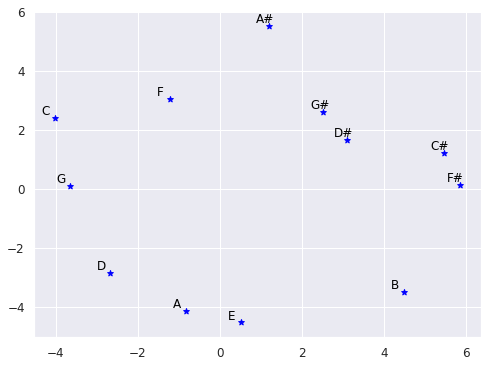

In [92]:
# Pasa los vectores luego del análisis de PCA
plot_5th_circle(last_tensor_pca)

Finalmente, tenemos la rueda de quintas dibujada.